In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, utils
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock, mutation_features, methylation_pred

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from pyfaidx import Fasta


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

/tmp/ipykernel_889713/3477137944.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-deep")


In [3]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output"
dependency_f_dir = "/cellar/users/zkoch/methylation_and_mutation/dependency_files"
data_dir = "/cellar/users/zkoch/methylation_and_mutation/data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
#methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/processed_methylation'
methylation_dir =  '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation_new'

# Read in tcga data

In [4]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))
# read in other already computed files8
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


# Read in comethylation results

In [ ]:
# literature meQTLS
lit_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/*db/all_metrics*")
lit_c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/031523_comethyl_output/*db/comparison_sites*")

lit_all_metrics_dfs = []
for path in lit_paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path)
    one_metrics_df = one_metrics_dd.compute()
    lit_all_metrics_dfs.append(one_metrics_df)
lit_all_metrics_df = pd.concat(lit_all_metrics_dfs)
lit_all_metrics_df.reset_index(inplace=True, drop=True)


lit_all_comparison_site_dfs = []
for path in lit_c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    lit_all_comparison_site_dfs.append(one_comp_df)
lit_all_comparison_site_df = pd.concat(lit_all_comparison_site_dfs)
lit_all_comparison_site_df.reset_index(inplace=True, drop=True)

In [5]:
# distance
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/comparison_sites*")

"""dist_all_metrics_dfs = []
for path in paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path)
    one_metrics_df = one_metrics_dd.compute()
    dist_all_metrics_dfs.append(one_metrics_df)
dist_all_metrics_df = pd.concat(dist_all_metrics_dfs)
dist_all_metrics_df.reset_index(inplace=True, drop=True)"""

dist_all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    dist_all_comparison_site_dfs.append(one_comp_df)
dist_all_comparison_site_df = pd.concat(dist_all_comparison_site_dfs)
dist_all_comparison_site_df.reset_index(inplace=True, drop=True)

dist_mean_metrics_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/mean_metrics_by_dist.parquet")

In [442]:
# correlation
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/correl_based_1000Top_no_mutMF/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/correl_based_1000Top_no_mutMF/comparison_sites*")

"""all_metrics_dfs = []
for path in paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path)
    one_metrics_df = one_metrics_dd.compute()
    all_metrics_dfs.append(one_metrics_df)
corr_all_metrics_df = pd.concat(all_metrics_dfs)
corr_all_metrics_df.reset_index(inplace=True, drop=True)"""


"""all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    all_comparison_site_dfs.append(one_comp_df)
corr_all_comparison_site_df = pd.concat(all_comparison_site_dfs)
corr_all_comparison_site_df.reset_index(inplace=True, drop=True)"""

corr_mean_metrics_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/correl_based_1000Top_no_mutMF/mean_metrics_by_dist_old.parquet")

# Figure 2

## Do plots

### 2A diagram

<AxesSubplot:>

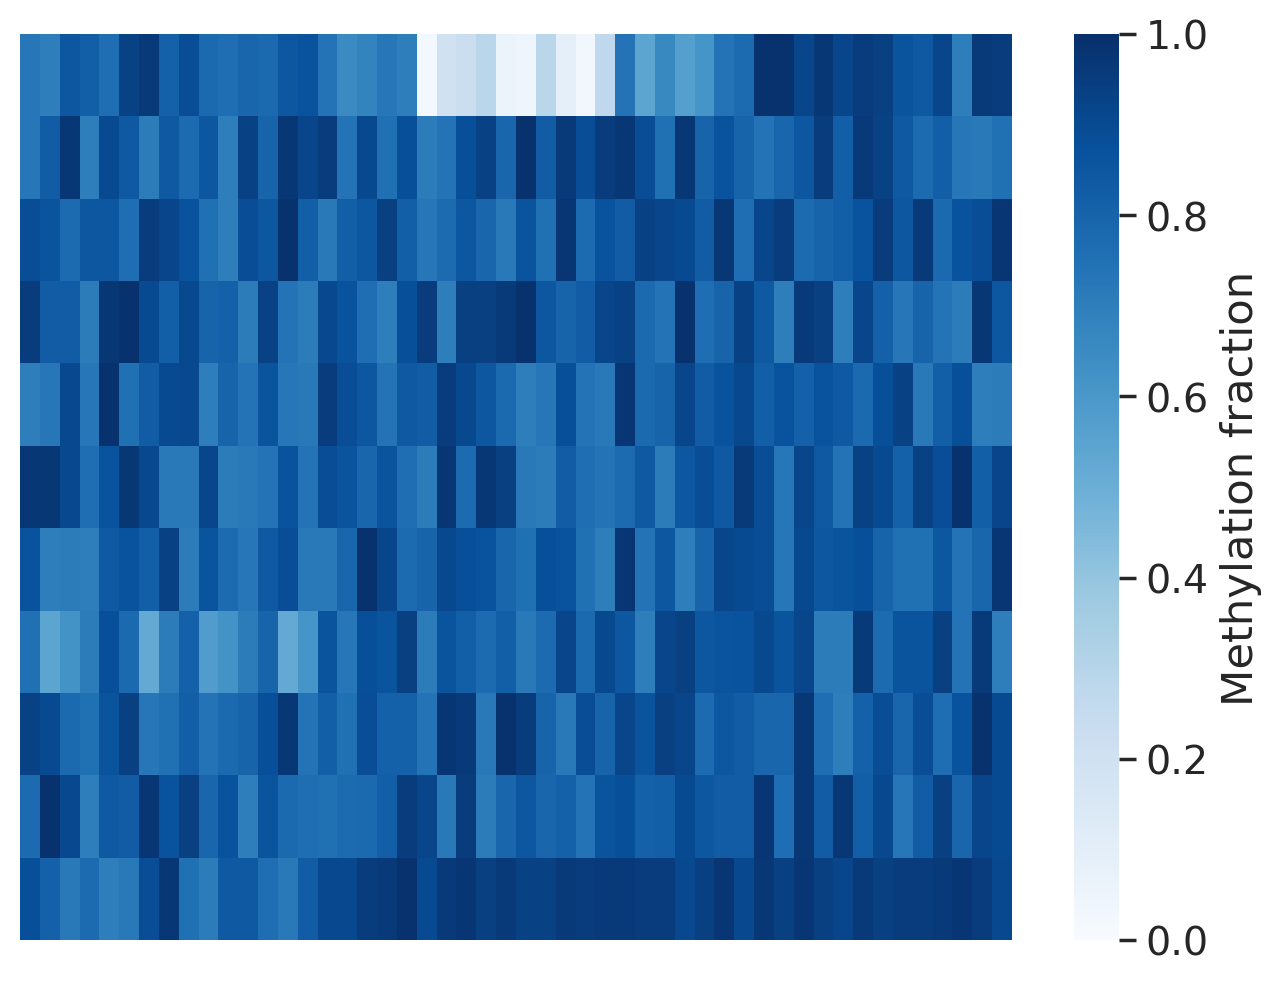

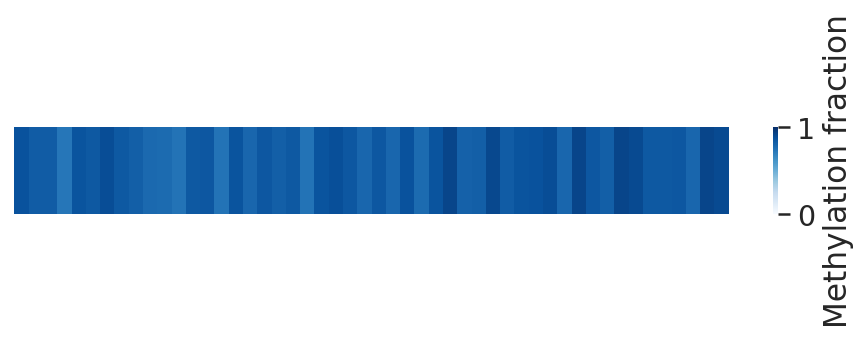

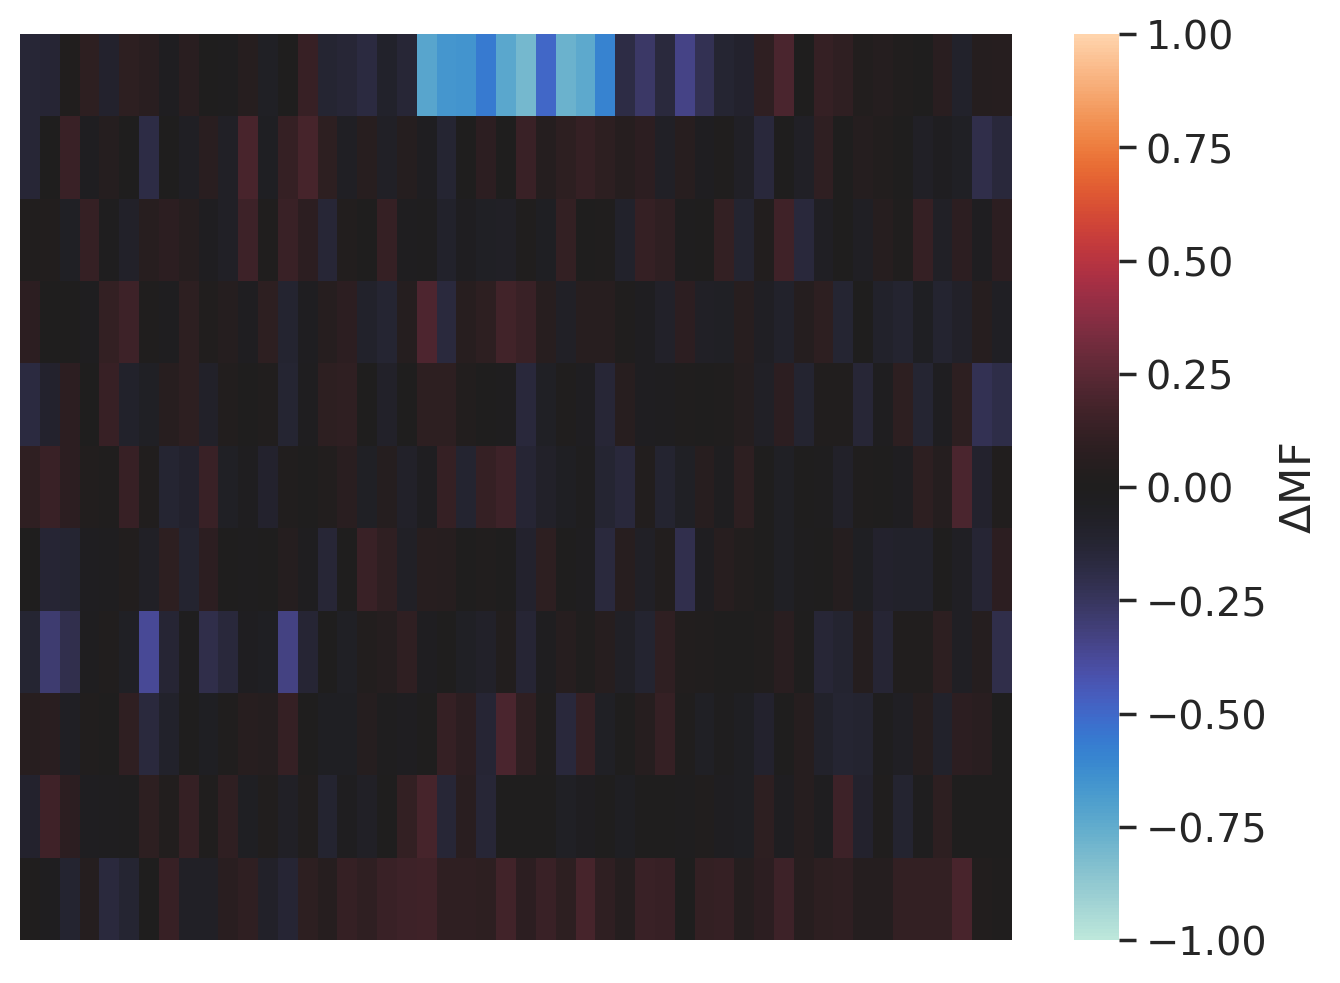

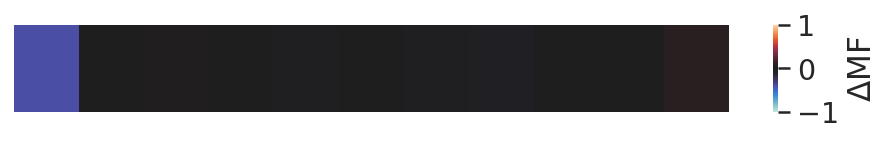

In [166]:
# create a 21 samples x 50 CpG site matrix of fake methylation values
# randomly generate
example_df = pd.DataFrame(np.random.randint(70, 100,size=(11, 50)))
a = np.random.randint(70, 100, size=(1, 15))
b =  np.random.randint(50, 80,size=(1, 5))
c = np.random.randint(0,30,size=(1, 10))
d = np.random.randint(50, 80,size=(1, 5))
e = np.random.randint(70, 100, size=(1, 15))
# set this as the first row of the matrix
example_df.iloc[0, :] = np.concatenate((a[0],b[0],c[0], d[0], e[0]))
# create another slightly divergent row
a = np.random.randint(50, 90, size=(1, 15))
b =  np.random.randint(70, 100,size=(1, 35))
example_df.iloc[7, :] = np.concatenate((a[0],b[0]))
# create another slightly divergent row
a = np.random.randint(70, 100, size=(1, 15))
b =  np.random.randint(90, 100,size=(1, 35))
example_df.iloc[10, :] = np.concatenate((a[0],b[0]))

example_df = example_df / 100

# plot as a heatmap
# label cbar
sns.set_theme(style='white', font_scale=1.3)
fig, axes = plt.subplots(1, 1, figsize=(8, 6), dpi = 100)
sns.heatmap(example_df, cmap = 'Blues', cbar = True, cbar_kws = {'label': 'Methylation fraction'},  annot=False, xticklabels=False, yticklabels=False,vmin=0, vmax=1, center=0.5, ax = axes)

# median
median = example_df.median(axis = 0).to_frame().T
sns.set_theme(style='white', font_scale=1.3)
fig, ax = plt.subplots(figsize=(8, .8))
sns.heatmap(median, cmap = 'Blues', cbar = True, cbar_kws = {'label': 'Methylation fraction'},  annot=False, xticklabels=False, yticklabels=False, vmin=0, vmax=1, center=0.5, )

# delta MF
# plot a median normalized versoin of example_df
# first, normalize each column by the median
example_df_norm = example_df.apply(lambda x: x - x.median(), axis = 0)
# plot as a heatmap
# label cbar
sns.set_theme(style='white', font_scale=1.3)
fig, axes = plt.subplots(1, 1, figsize=(8, 6), dpi = 100)

sns.heatmap(example_df_norm, cmap = 'icefire', cbar = True, vmin=-1, vmax=1, center=0, cbar_kws = {'label': r'$\Delta$MF'},  annot=False, yticklabels=False, xticklabels=False, ax = axes)


# get row mean of example_df_norm
row_means = example_df_norm.mean(axis = 1).to_frame()
row_means.iloc[0] = -.4
row_means = row_means.T
# plot as a heatmap
# label cbar
sns.set_theme(style='white', font_scale=1.3)

fig, ax = plt.subplots(figsize=(8, .8))
sns.heatmap(row_means, cmap = 'icefire', cbar = True, cbar_kws = {'label': r'$\Delta$MF'},  annot=False, xticklabels=False, yticklabels=False, vmin=-1, vmax=1, center=0)

### Mean metrics

In [7]:
analyze_comethylation = compute_comethylation.analyzeComethylation()

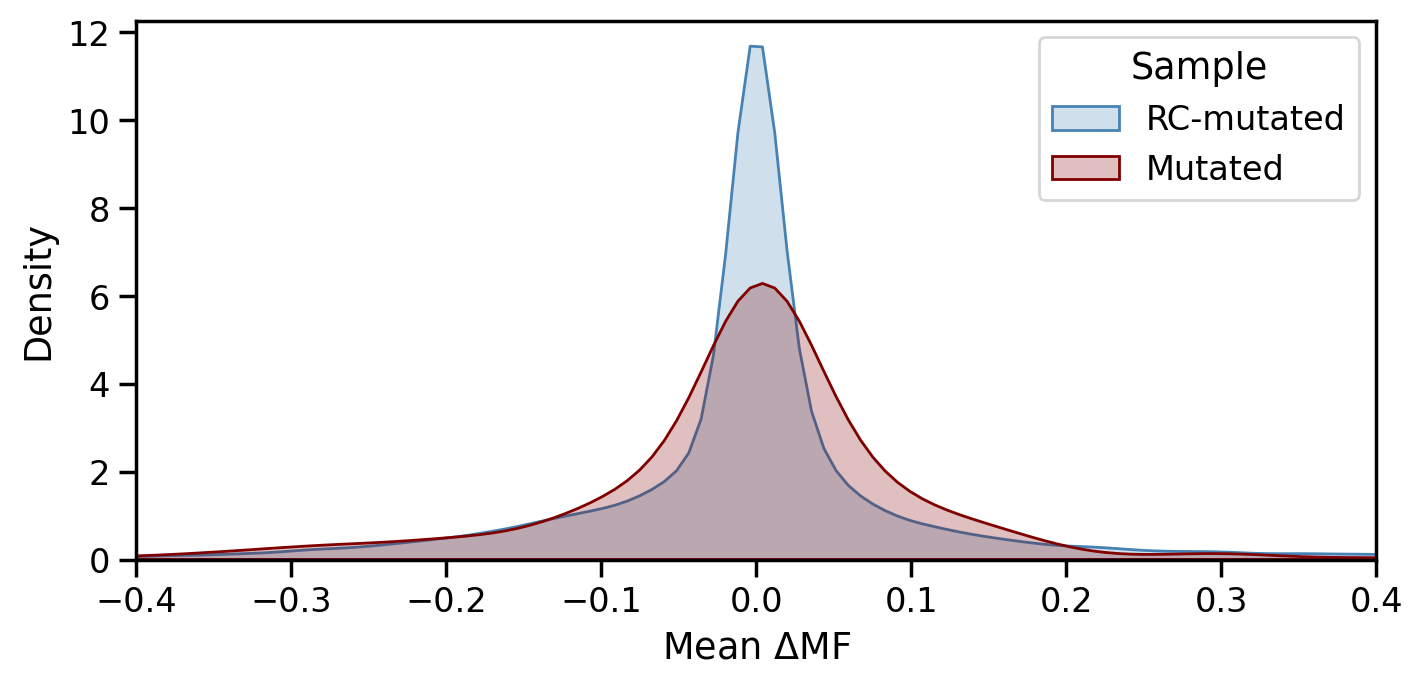

In [79]:
# new corr
# chosen 10 top sites
for dist in [10]:# corr_mean_metrics_df['distance'].unique():
    analyze_comethylation.plot_delta_mf_kdeplot(
        corr_mean_metrics_df.loc[corr_mean_metrics_df['distance'] == dist],
        metric = 'median_dmf'
        )

10000


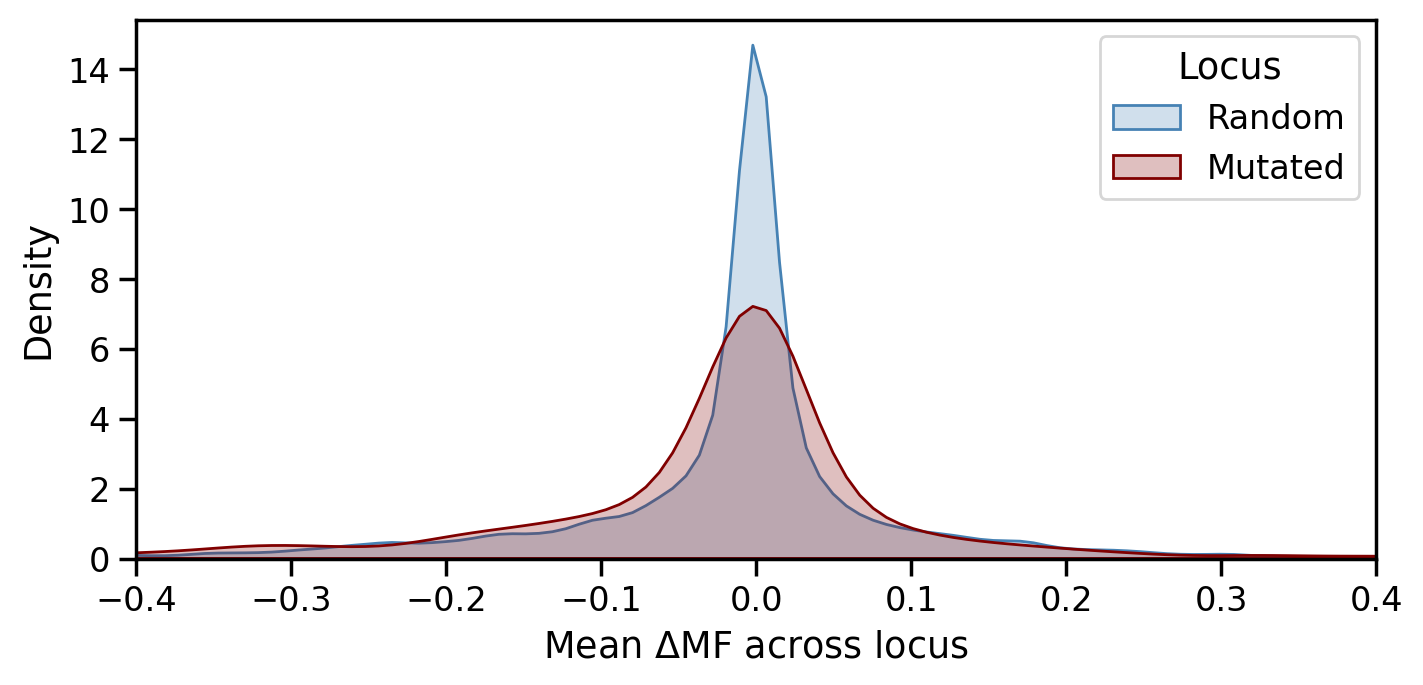

In [8]:
# 5000 chosen
for dist in [10000]:# dist_mean_metrics_df['distance'].unique():
    print(dist)
    analyze_comethylation.plot_delta_mf_kdeplot(
        dist_mean_metrics_df.loc[dist_mean_metrics_df['distance'] == dist],
        metric = 'median_dmf'
        )

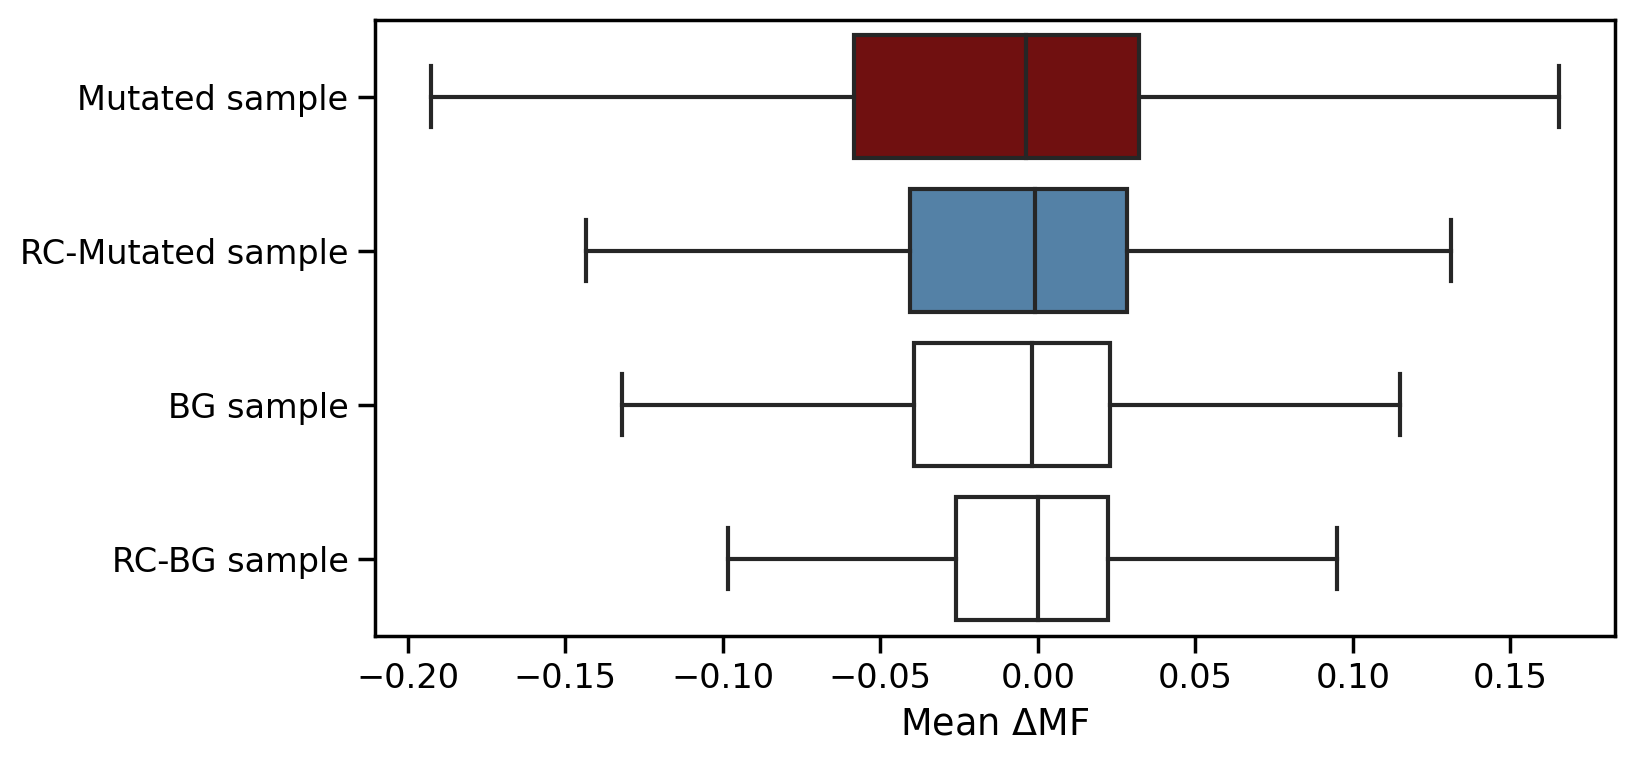

In [84]:
# new corr
for dist in [10]:# corr_mean_metrics_df['distance'].unique():
    analyze_comethylation.plot_delta_mf_boxplots(
        corr_mean_metrics_df.loc[corr_mean_metrics_df['distance'] == dist]
        )

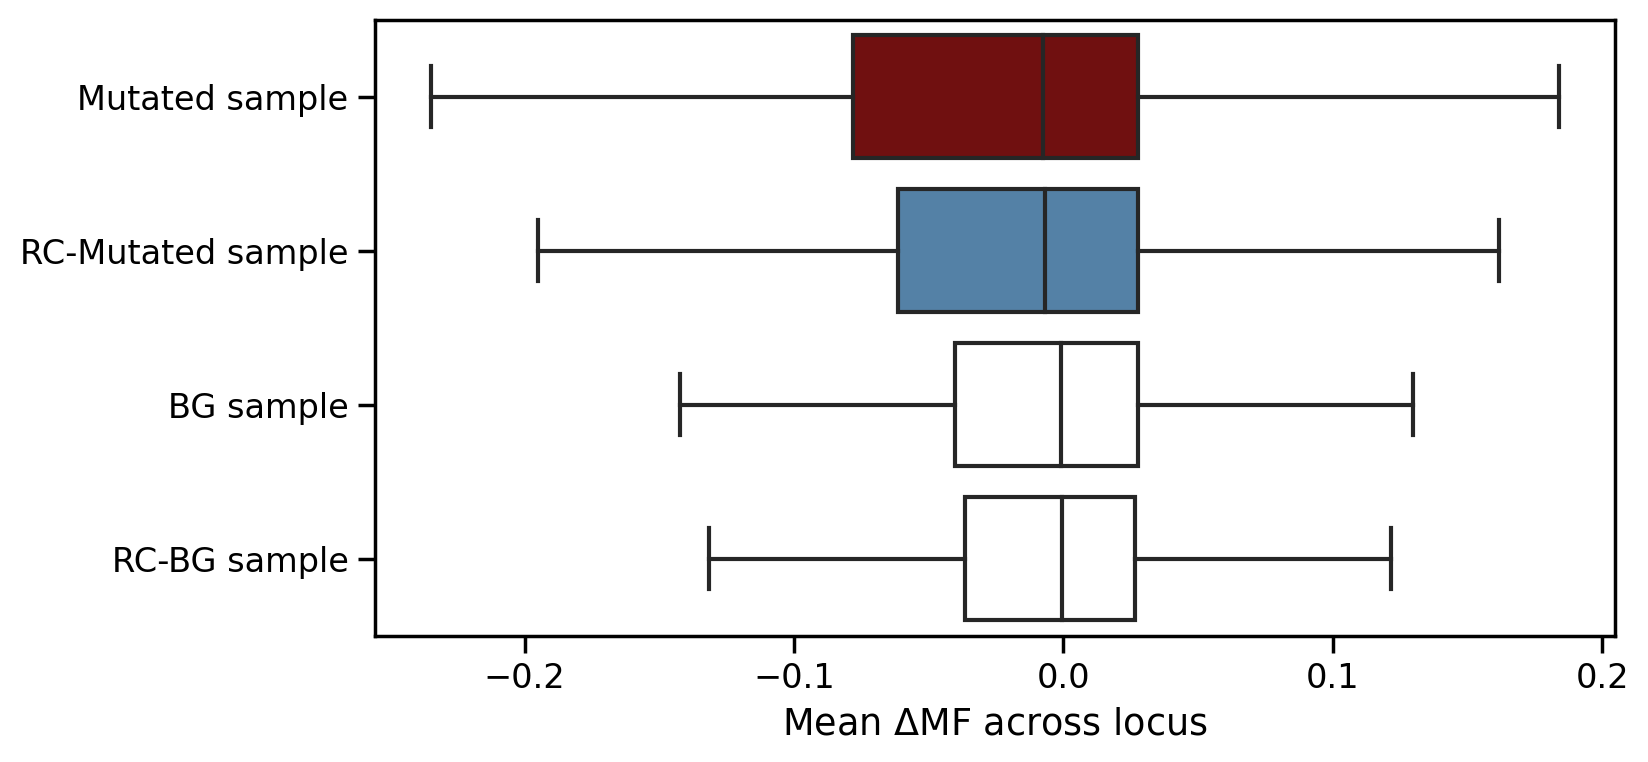

In [94]:
for dist in [5000]:# dist_mean_metrics_df['distance'].unique():
    analyze_comethylation.plot_delta_mf_boxplots(
        dist_mean_metrics_df.loc[dist_mean_metrics_df['distance'] == dist]
        )

### All metrics

##### Distance

In [ ]:
biggest_neg_effect = dist_mean_metrics_df.loc[
    (dist_mean_metrics_df['distance'] == 5000)
    & (dist_mean_metrics_df['mutated_sample'] == True)
    & (dist_mean_metrics_df['is_background'] == False)
    ].sort_values(by='mean_dmf', ascending=False).tail(250)['mut_event'].values
# then select these events (and their randomized controle vents) from the non-mean
biggest_neg_to_plot = dist_all_metrics_df.loc[
    (dist_all_metrics_df['mut_event'].isin(biggest_neg_effect))
    | (dist_all_metrics_df['index_event'].isin(biggest_neg_effect))
]

In [150]:
dist_all_metrics_df.query("mut_event in @biggest_neg_effect or index_event in @biggest_neg_effect")

MemoryError: Unable to allocate 11.8 GiB for an array with shape (1588899453,) and data type int64

In [149]:
# new
analyze_comethylation.plot_distance_of_effect(
    dist_all_metrics_df.query("mut_event in @biggest_neg_effect or index_event in @biggest_neg_effect"), 
    num_bins=10,
    min_dist = -100000, max_dist = 100000
    )

MemoryError: Unable to allocate 11.8 GiB for an array with shape (1588899453,) and data type int64

/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_events['dist_bin'] = pd.cut(


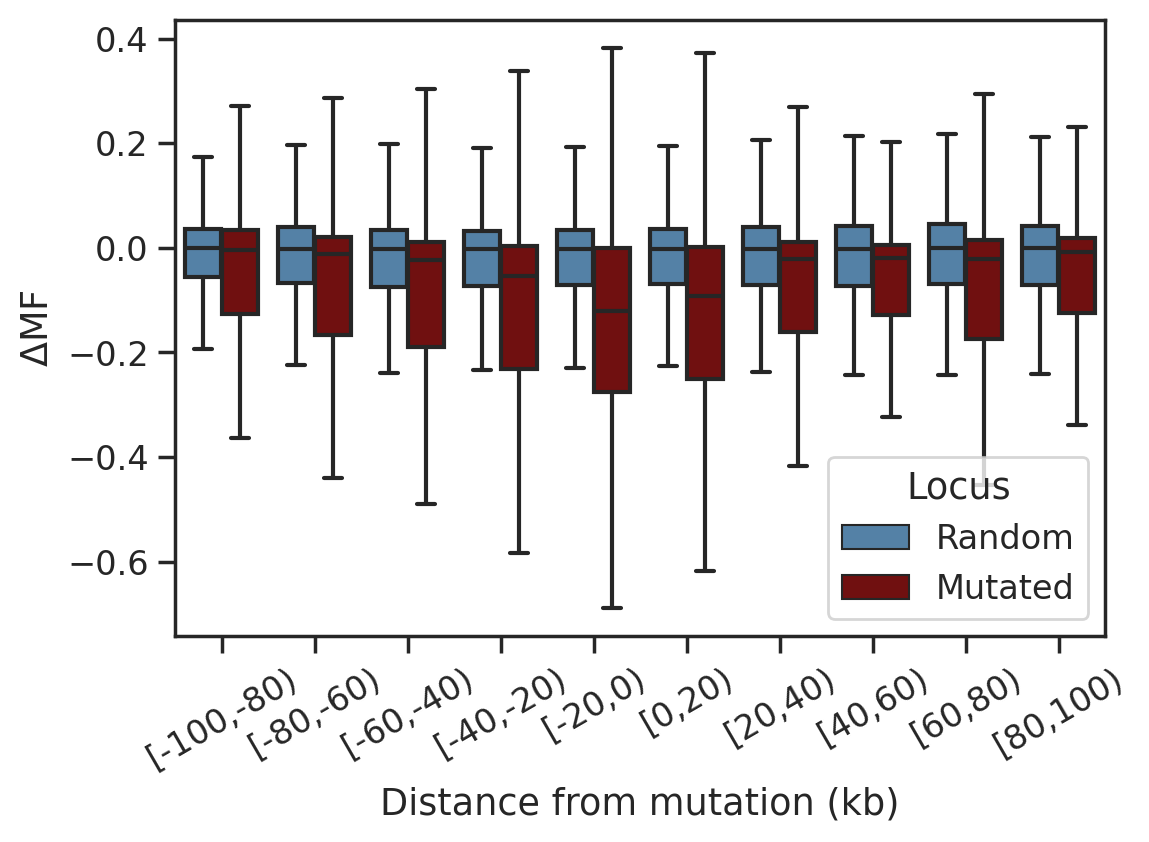

In [55]:
analyze_comethylation.plot_distance_of_effect(
    biggest_neg_to_plot, num_bins=10,
    min_dist = -100000, max_dist = 100000
    )

##### Corr

In [ ]:
biggest_neg_effect_df = corr_mean_metrics_df.loc[
    (corr_mean_metrics_df['distance'] == 10)
    & (corr_mean_metrics_df['mutated_sample'] == True)
    & (corr_mean_metrics_df['is_background'] == False)
    ].sort_values(by='mean_dmf', ascending=False)
biggest_neg_effect = biggest_neg_effect_df.tail(250)['mut_event'].values
# then select these events (and their randomized controle vents) from the non-mean
biggest_neg_to_plot = corr_all_metrics_df.loc[
    (corr_all_metrics_df['mut_event'].isin(biggest_neg_effect))
    | (corr_all_metrics_df['index_event'].isin(biggest_neg_effect))
]

/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels = [


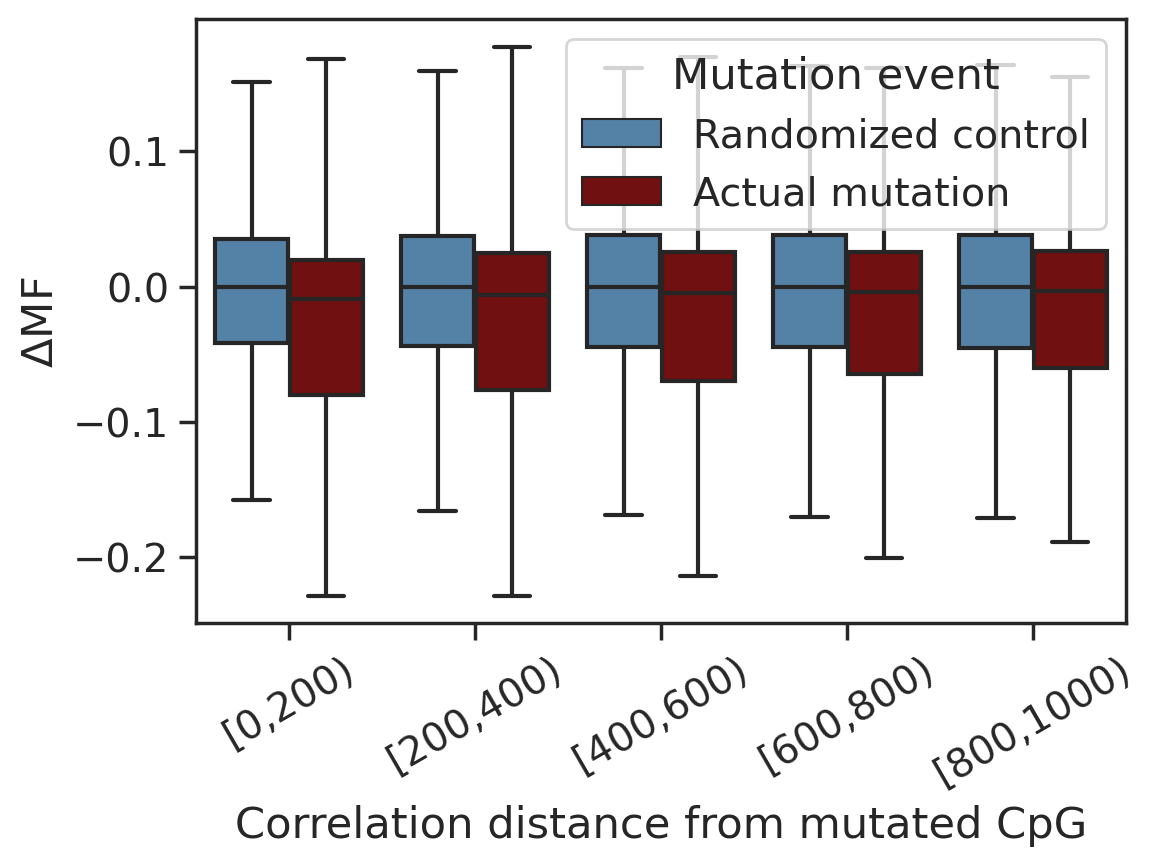

In [17]:
analyze_comethylation.plot_distance_of_effect(
    biggest_neg_to_plot, num_bins=5,
    min_dist = 0, max_dist = 1000,
    method = 'corr'
    )

### Find good supernova

In [6]:
# TODO: add a criteria for background samples not being very variable
# TODO: add a criteria for number of comparison sites in each range
def possible_good_supernovas(
    mean_metrics_df: pd.DataFrame, 
    close_dist: int,
    far_dist: int,
    metric: str = 'mean_dmf',
    comparison_site_df: pd.DataFrame = None
    ):
    """
    Given a mean metrics df, find mutation events where np.abs(close_dist) - np.abs(far_dist) is the biggest
    """
    # get the mean metric for the close dist
    close_dists = mean_metrics_df.loc[
        (mean_metrics_df['distance'] == close_dist)
        #& (mean_metrics_df['mutated_sample'] == True)
        & (mean_metrics_df['is_background'] == False),
        ['mut_event', 'sample', 'mutated_sample', metric]
        ]
    # and for the far dist
    far_dists = mean_metrics_df.loc[
        (mean_metrics_df['distance'] == far_dist)
        #& (mean_metrics_df['mutated_sample'] == True)
        & (mean_metrics_df['is_background'] == False),
        ['mut_event', 'sample', 'mutated_sample', metric]
        ]
    print( close_dists.shape, far_dists.shape)
    # merge the two
    merged = pd.merge(
        close_dists, far_dists, 
        on=['mut_event', 'sample'], 
        suffixes=[f'_{close_dist}_close', f'_{far_dist}']
        )
    # take the difference
    merged['abs_diff'] = merged[f'{metric}_{close_dist}'].abs() - merged[f'{metric}_{far_dist}'].abs()
    """# get the mean diffs of matched samples for each
    bg_close_dists = mean_metrics_df.loc[
        (mean_metrics_df['distance'] == close_dist)
        & (mean_metrics_df['mutated_sample'] == False)
        & (mean_metrics_df['is_background'] == False),
        ['mut_event', 'sample', metric]
        ]
    bg_far_dists = mean_metrics_df.loc[
        (mean_metrics_df['distance'] == far_dist)
        & (mean_metrics_df['mutated_sample'] == False)
        & (mean_metrics_df['is_background'] == False),
        ['mut_event', 'sample', metric]
        ]"""
    # join with merged on 
    
    if comparison_site_df is not None:
        # merge with the comparison site df on mut_event 
        merged = pd.merge(merged, comparison_site_df, on='mut_event', how='left')
    
    return merged.sort_values(by='abs_diff', ascending=False)

##### Dist

In [7]:
dist_all_comparison_site_df['num_comp_sites'] = dist_all_comparison_site_df['comparison_dists'].apply(lambda x: len(x))
#dist_all_comparison_site_df['num_comp_sites_1000'] = dist_all_comparison_site_df['comparison_dists'].apply(lambda x: len([i for i in x if np.abs(i) < 1000]))
dist_all_comparison_site_df['num_comp_sites_5000'] = dist_all_comparison_site_df['comparison_dists'].apply(lambda x: len([i for i in x if np.abs(i) < 5000]))
dist_all_comparison_site_df['num_comp_sites_10000'] = dist_all_comparison_site_df['comparison_dists'].apply(lambda x: len([i for i in x if np.abs(i) < 10000]))
dist_all_comparison_site_df['num_comp_sites_50000'] = dist_all_comparison_site_df['comparison_dists'].apply(lambda x: len([i for i in x if np.abs(i) < 50000]))
dist_all_comparison_site_df['num_comp_sites_100000'] = dist_all_comparison_site_df['comparison_dists'].apply(lambda x: len([i for i in x if np.abs(i) < 100000]))

In [8]:
supernova_candidates = possible_good_supernovas(
    dist_mean_metrics_df, close_dist = 100000, far_dist = 100000,
    comparison_site_df = dist_all_comparison_site_df
    )

(240140, 4) (240140, 4)


In [9]:
supernova_candidates_grouped = supernova_candidates.groupby(['mut_event', 'mutated_sample_100000']).mean().reset_index()
mut_minus_matched = {}
for mut_event in supernova_candidates_grouped['mut_event'].unique(): 
    mut = supernova_candidates_grouped.loc[(supernova_candidates_grouped['mut_event'] == mut_event) & (supernova_candidates_grouped['mutated_sample_100000'] == True), 'abs_diff']
    matched = supernova_candidates_grouped.loc[(supernova_candidates_grouped['mut_event'] == mut_event) & (supernova_candidates_grouped['mutated_sample_100000'] == False), 'abs_diff']
    mut_minus_matched[mut_event]= mut.values[0] - matched.values[0]

mut_minus_matched_df = pd.DataFrame.from_dict(mut_minus_matched, orient='index', columns=['mut_minus_matched']).reset_index()
mut_minus_matched_df.columns = ['mut_event', 'mut_minus_matched']
supernova_candidates_mut_only = supernova_candidates.loc[supernova_candidates['mutated_sample_100000'] == True]
# merge on mut_event
supernova_candidates_mut_only_merged = supernova_candidates_mut_only.merge(mut_minus_matched_df, on='mut_event', how='left')

/tmp/ipykernel_889713/2214053663.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  supernova_candidates_grouped = supernova_candidates.groupby(['mut_event', 'mutated_sample_100000']).mean().reset_index()


In [10]:
supernova_candidates_mut_only_merged.loc[supernova_candidates_mut_only_merged['num_comp_sites_100000']>100].sort_values(by='mean_dmf_100000_close', ascending=False).head(20)

,mut_event,sample,mutated_sample_100000_close,mean_dmf_100000_close,mutated_sample_100000,mean_dmf_100000,abs_diff,case_submitter_id,chr,start,...,num_matched_samples,is_background,index_event,mut_delta_mf,num_comp_sites,num_comp_sites_5000,num_comp_sites_10000,num_comp_sites_50000,num_comp_sites_100000,mut_minus_matched
1767,TCGA-95-7043_3:147128676,TCGA-95-7043,True,0.240410,True,0.240410,0.0,TCGA-95-7043,3,147128676,...,159.0,False,self,NaN,122,39,54,107,122,0.0
763,TCGA-GV-A3QI_16:56642556,TCGA-GV-A3QI,True,0.230735,True,0.230735,0.0,TCGA-GV-A3QI,16,56642556,...,28.0,False,self,NaN,106,6,9,65,106,0.0
136,TCGA-FB-AAPP_20:57484420,TCGA-FB-AAPP,True,0.173964,True,0.173964,0.0,TCGA-FB-AAPP,20,57484420,...,61.0,False,self,NaN,200,2,2,67,200,0.0
1133,TCGA-GN-A268_12:115117741,TCGA-GN-A268,True,0.118582,True,0.118582,0.0,TCGA-GN-A268,12,115117741,...,45.0,False,self,NaN,115,14,33,104,115,0.0
430,TCGA-EE-A20C_16:56704472,TCGA-EE-A20C,True,0.091866,True,0.091866,0.0,TCGA-EE-A20C,16,56704472,...,117.0,False,self,NaN,106,14,24,80,106,0.0
2184,TCGA-E5-A4TZ_17:46703274,TCGA-E5-A4TZ,True,0.081388,True,0.081388,0.0,TCGA-E5-A4TZ,17,46703274,...,141.0,False,self,NaN,263,17,36,158,263,0.0
1036,TCGA-VS-A8EJ_17:7578275,TCGA-VS-A8EJ,True,0.074691,True,0.074691,0.0,TCGA-VS-A8EJ,17,7578275,...,55.0,False,self,NaN,117,6,6,58,117,0.0
1117,TCGA-GN-A262_5:480074,TCGA-GN-A262,True,0.070886,True,0.070886,0.0,TCGA-GN-A262,5,480074,...,93.0,False,self,NaN,186,15,29,112,186,0.0
2418,TCGA-D9-A6EC_12:57966372,TCGA-D9-A6EC,True,0.066711,True,0.066711,0.0,TCGA-D9-A6EC,12,57966372,...,114.0,False,self,NaN,140,2,2,84,140,0.0
715,TCGA-N5-A4RS_11:1155683,TCGA-N5-A4RS,True,0.064796,True,0.064796,0.0,TCGA-N5-A4RS,11,1155683,...,27.0,False,self,NaN,124,9,11,20,124,0.0


In [11]:
analyze_comethylation = compute_comethylation.analyzeComethylation()

In [490]:
all_mut_w_age_df.loc[(all_mut_w_age_df['case_submitter_id'] == 'TCGA-GV-A3QI') & (all_mut_w_age_df['chr'] == '16') & (all_mut_w_age_df['start'] == 56642556)]

,case_submitter_id,chr,start,end,reference,alt,DNA_VAF,mutation,dataset,gender,age_at_index,dataset_r,gender_r
2413922,TCGA-GV-A3QI,16,56642556,56642556,C,T,0.96,C>T,BLCA,MALE,47,BLCA,MALE


-426 205 20


/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:432: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


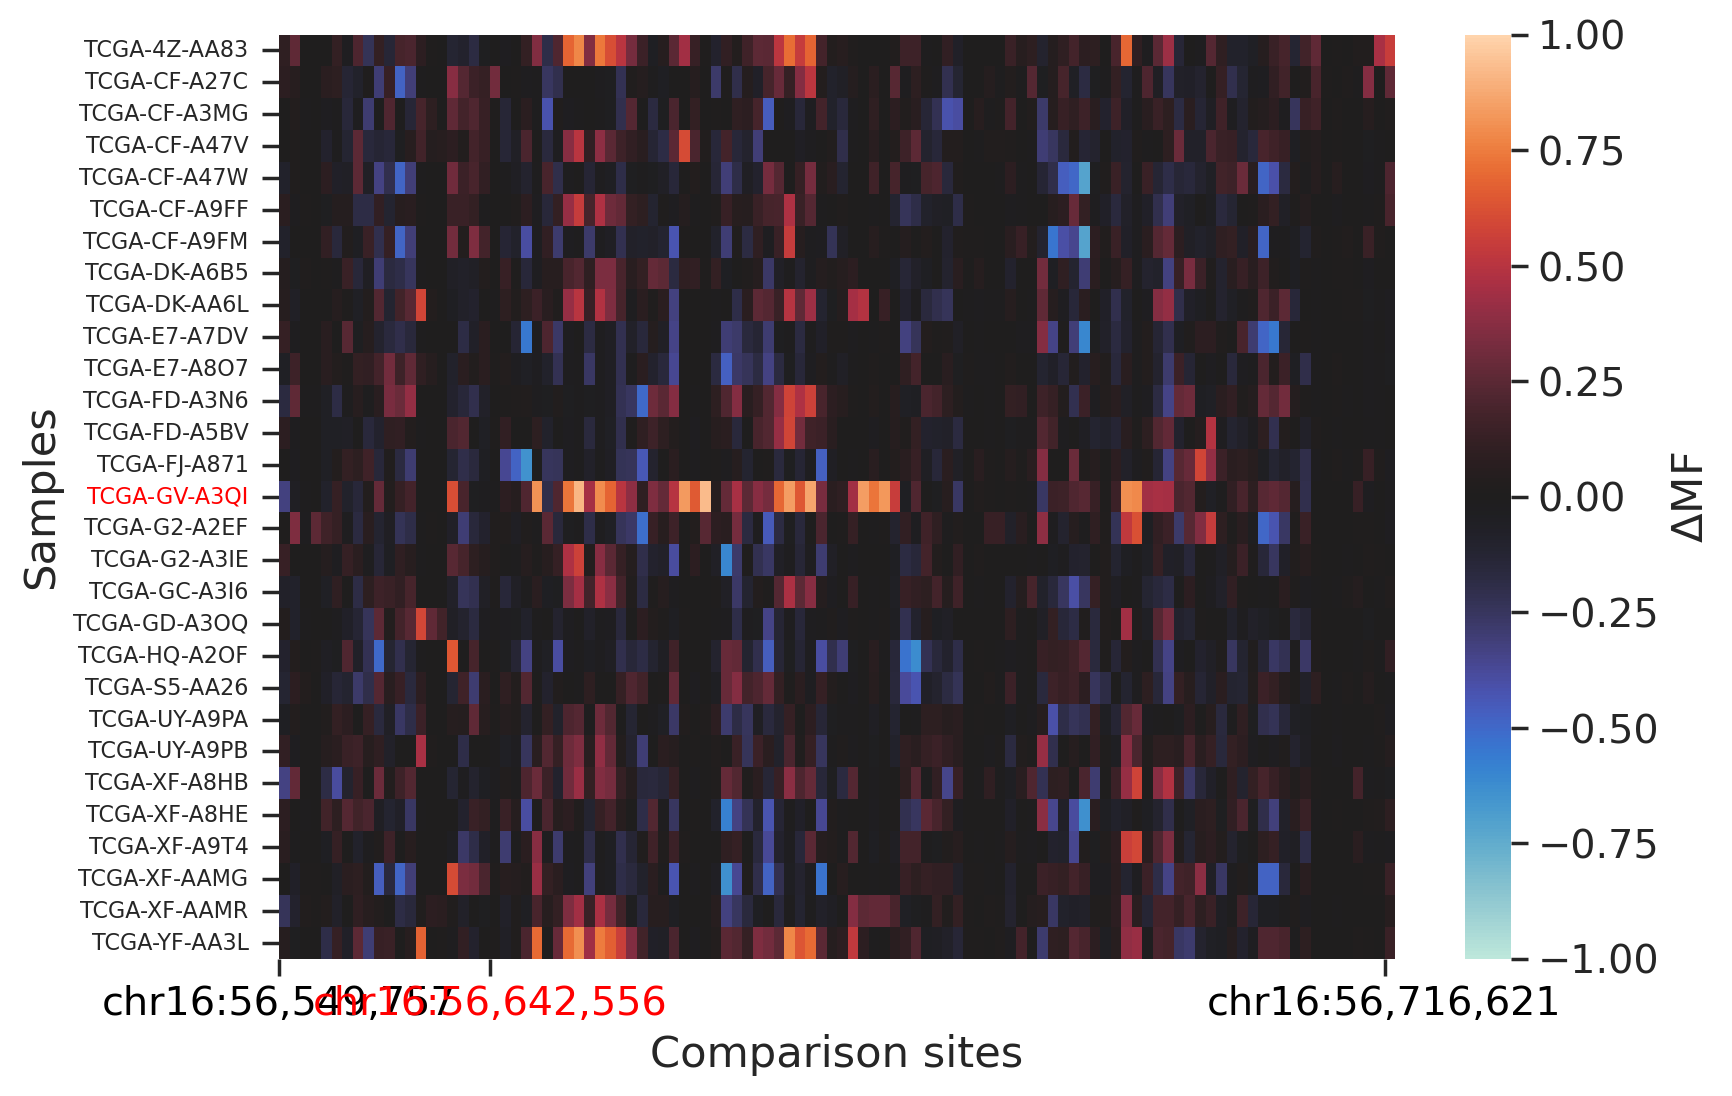

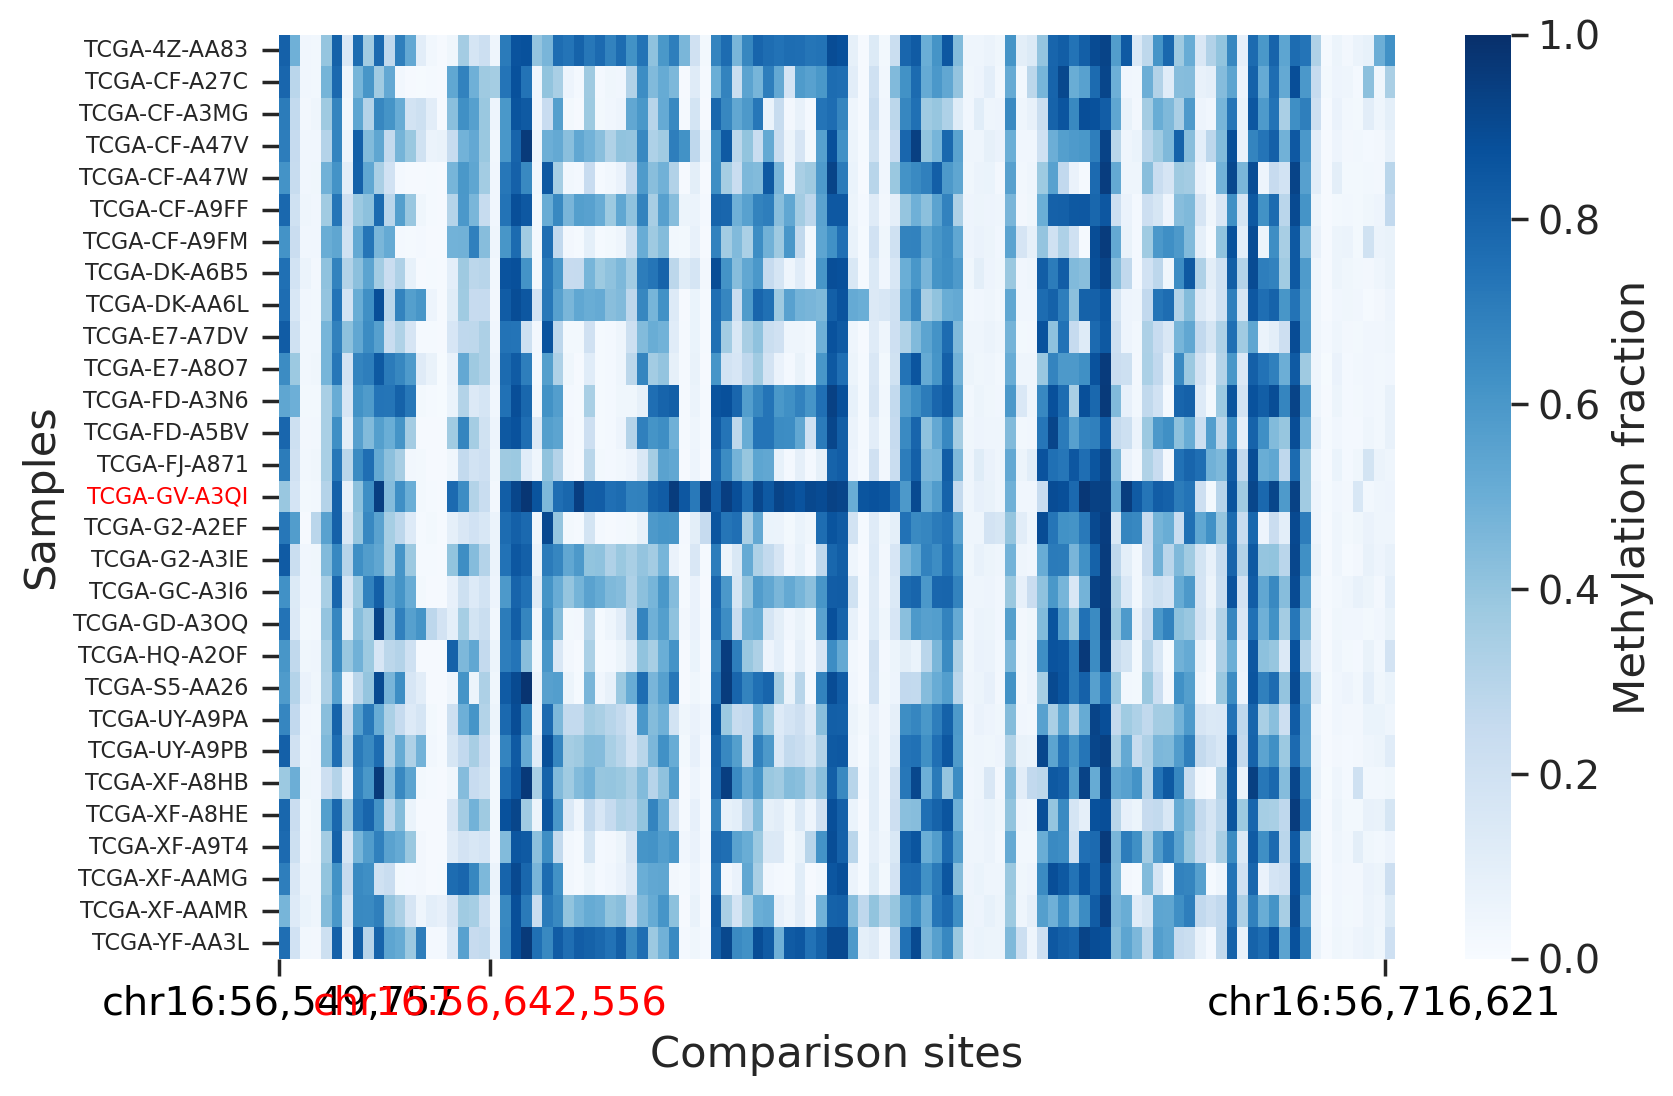

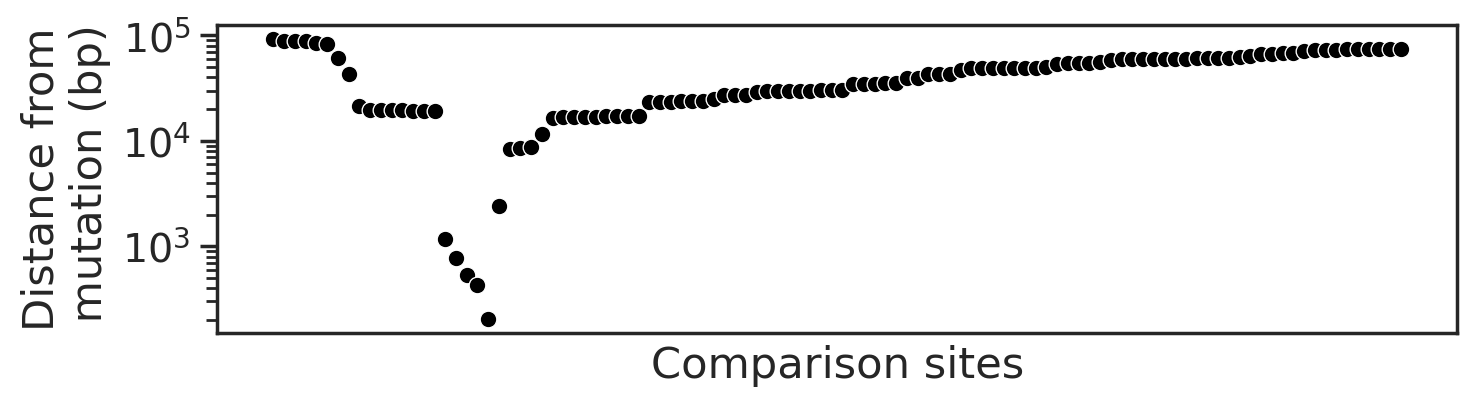

In [12]:
# best: TCGA-85-8352_5:140346535, TCGA-DX-AB30_18:56892844

# chosen: TCGA-D3-A3ML_15:25335137, TCGA-GV-A3QI_16:56642556 (comparison_sites[:-26])
# TCGA-95-7043_3:147128676
all_samples_comp_sites, all_samples_comp_sites_dmf, comparison_site_and_distances = analyze_comethylation.plot_heatmap_dist(
    mut_event = 'TCGA-GV-A3QI_16:56642556', comparison_sites_df = dist_all_comparison_site_df,all_methyl_age_df_t = all_methyl_age_df_t,  rolling_window_size = 1,
    max_matched_samples = 10000, max_abs_distance = 10e9
)

-426 205 10


/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:432: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  # plot correlation distance on the same plot with y axis on the right


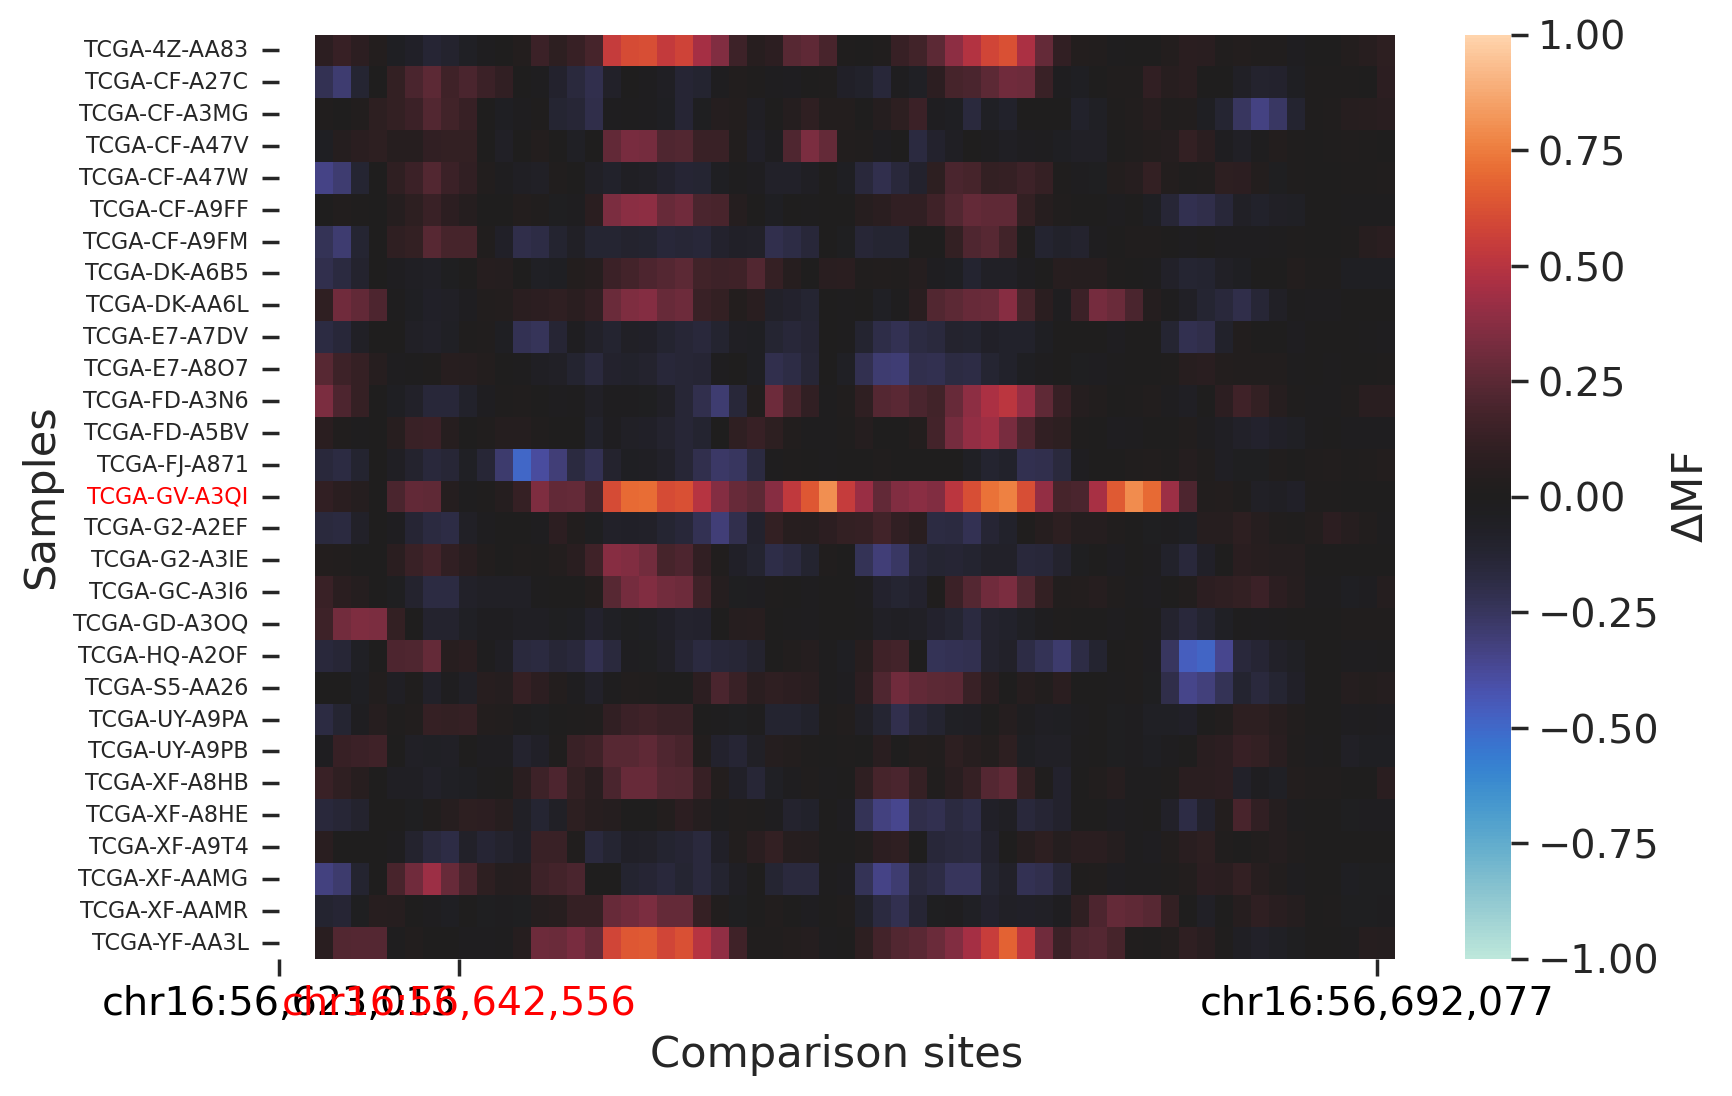

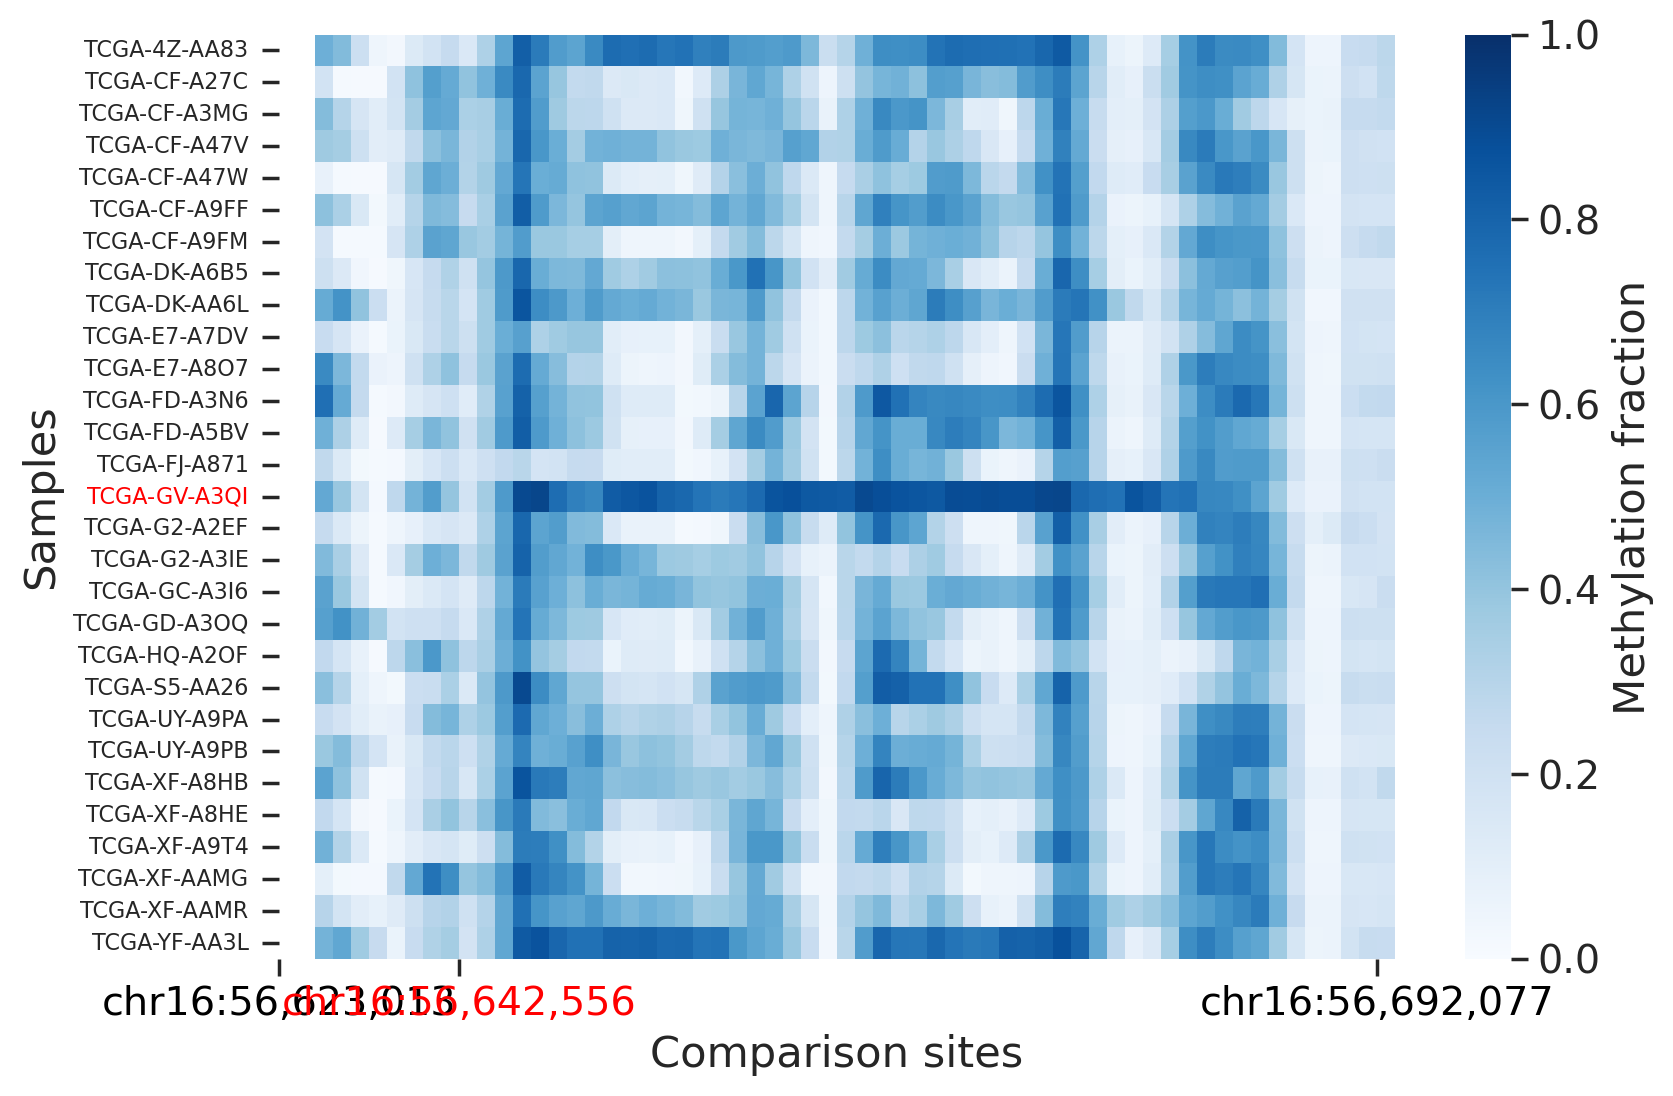

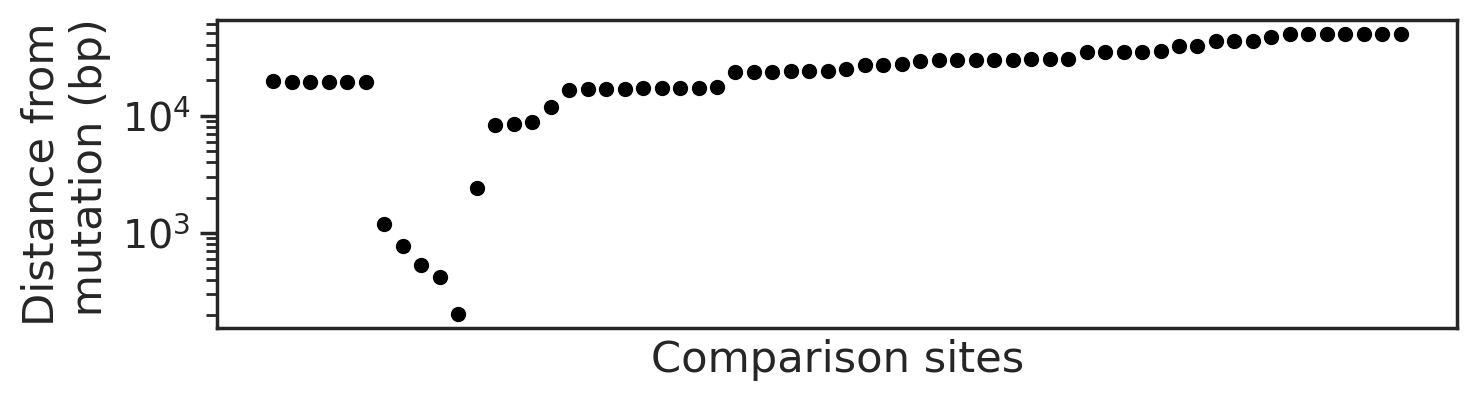

In [398]:
# best: TCGA-85-8352_5:140346535, TCGA-DX-AB30_18:56892844

# chosen: TCGA-D3-A3ML_15:25335137, TCGA-GV-A3QI_16:56642556 (comparison_sites[:-26])
# TCGA-95-7043_3:147128676
all_samples_comp_sites, all_samples_comp_sites_dmf, comparison_site_and_distances = analyze_comethylation.plot_heatmap_dist(
    mut_event = 'TCGA-GV-A3QI_16:56642556', comparison_sites_df = dist_all_comparison_site_df,all_methyl_age_df_t = all_methyl_age_df_t,  rolling_window_size = 1,
    max_matched_samples = 10000, max_abs_distance = 10e9
)

In [ ]:
_, axes = plt.subplots(figsize=(1,6), dpi=100)
sns.heatmap(all_samples_comp_sites_dmf.median(axis = 1).values.reshape(-1,1), cmap='icefire', center=-0, vmin=-1, vmax=1, ax = axes)

In [462]:
all_samples_comp_sites_dmf.shape

(29, 62)

##### Corr

In [167]:
corr_supernova_candidates = possible_good_supernovas(corr_mean_metrics_df, close_dist = 10, far_dist = 50).head(500)

(335, 3) (335, 3)


In [168]:
# for each of the top mut events, get the absolute sum of mean dmf's of their matched samples
bg_samples_sums = corr_mean_metrics_df.loc[
    (corr_mean_metrics_df['mut_event'].isin(corr_supernova_candidates['mut_event']))
    & (corr_mean_metrics_df['distance'] == 50)
    & (corr_mean_metrics_df['mutated_sample'] == False)
].groupby('mut_event')['mean_dmf'].apply(lambda x: abs(x).sum())
# make df and name the column
bg_samples_sums = pd.DataFrame(bg_samples_sums).rename(columns={'mean_dmf': 'bg_samples_sum'})
# merge with the supernova candidates
corr_supernova_candidates = pd.merge(corr_supernova_candidates, bg_samples_sums, on='mut_event', how='left')

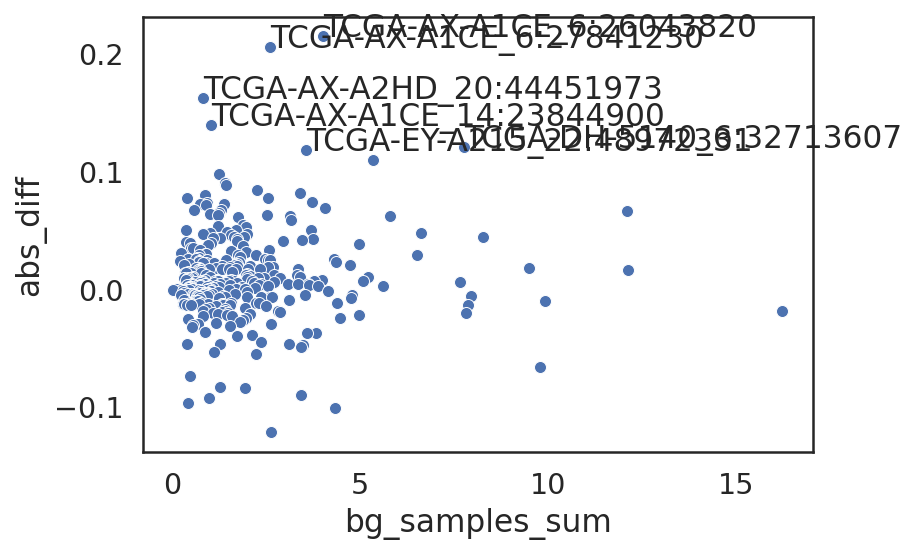

In [169]:
sns.scatterplot(data=corr_supernova_candidates, x='bg_samples_sum', y='abs_diff')
# label the points
for i, row in corr_supernova_candidates.iterrows():
    plt.text(row['bg_samples_sum'], row['abs_diff'], row['mut_event'])
    if i == 5:
        break

In [174]:
corr_supernova_candidates.loc[
    (corr_supernova_candidates['bg_samples_sum']< 2)
    #& (corr_supernova_candidates['abs_diff'] > .05)
].sort_values(by='abs_diff', ascending=False)

,mut_event,sample,mean_dmf_10,mean_dmf_50,abs_diff,bg_samples_sum
2,TCGA-AX-A2HD_20:44451973,TCGA-AX-A2HD,0.246844,0.084644,0.162200,0.836571
3,TCGA-AX-A1CE_14:23844900,TCGA-AX-A1CE,-0.412194,-0.273235,0.138959,1.044455
7,TCGA-EO-A1Y7_20:36147549,TCGA-EO-A1Y7,-0.201155,-0.103639,0.097516,1.259798
8,TCGA-G3-AAV0_13:110434682,TCGA-G3-AAV0,-0.125158,-0.035511,0.089647,1.410574
9,TCGA-EO-A22R_8:87076603,TCGA-EO-A22R,-0.175002,-0.086889,0.088112,1.448115
...,...,...,...,...,...,...
327,TCGA-EE-A20C_21:44590650,TCGA-EE-A20C,-0.020301,-0.094511,-0.074210,0.486060
328,TCGA-AP-A1DP_8:142238452,TCGA-AP-A1DP,-0.023365,-0.106491,-0.083127,1.280987
329,TCGA-AP-A1DV_10:101293089,TCGA-AP-A1DV,0.161039,0.245153,-0.084114,1.933767
331,TCGA-DU-6392_19:39691388,TCGA-DU-6392,-0.050081,-0.142992,-0.092911,0.995766


0 1 1


/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:324: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_yscale('log')


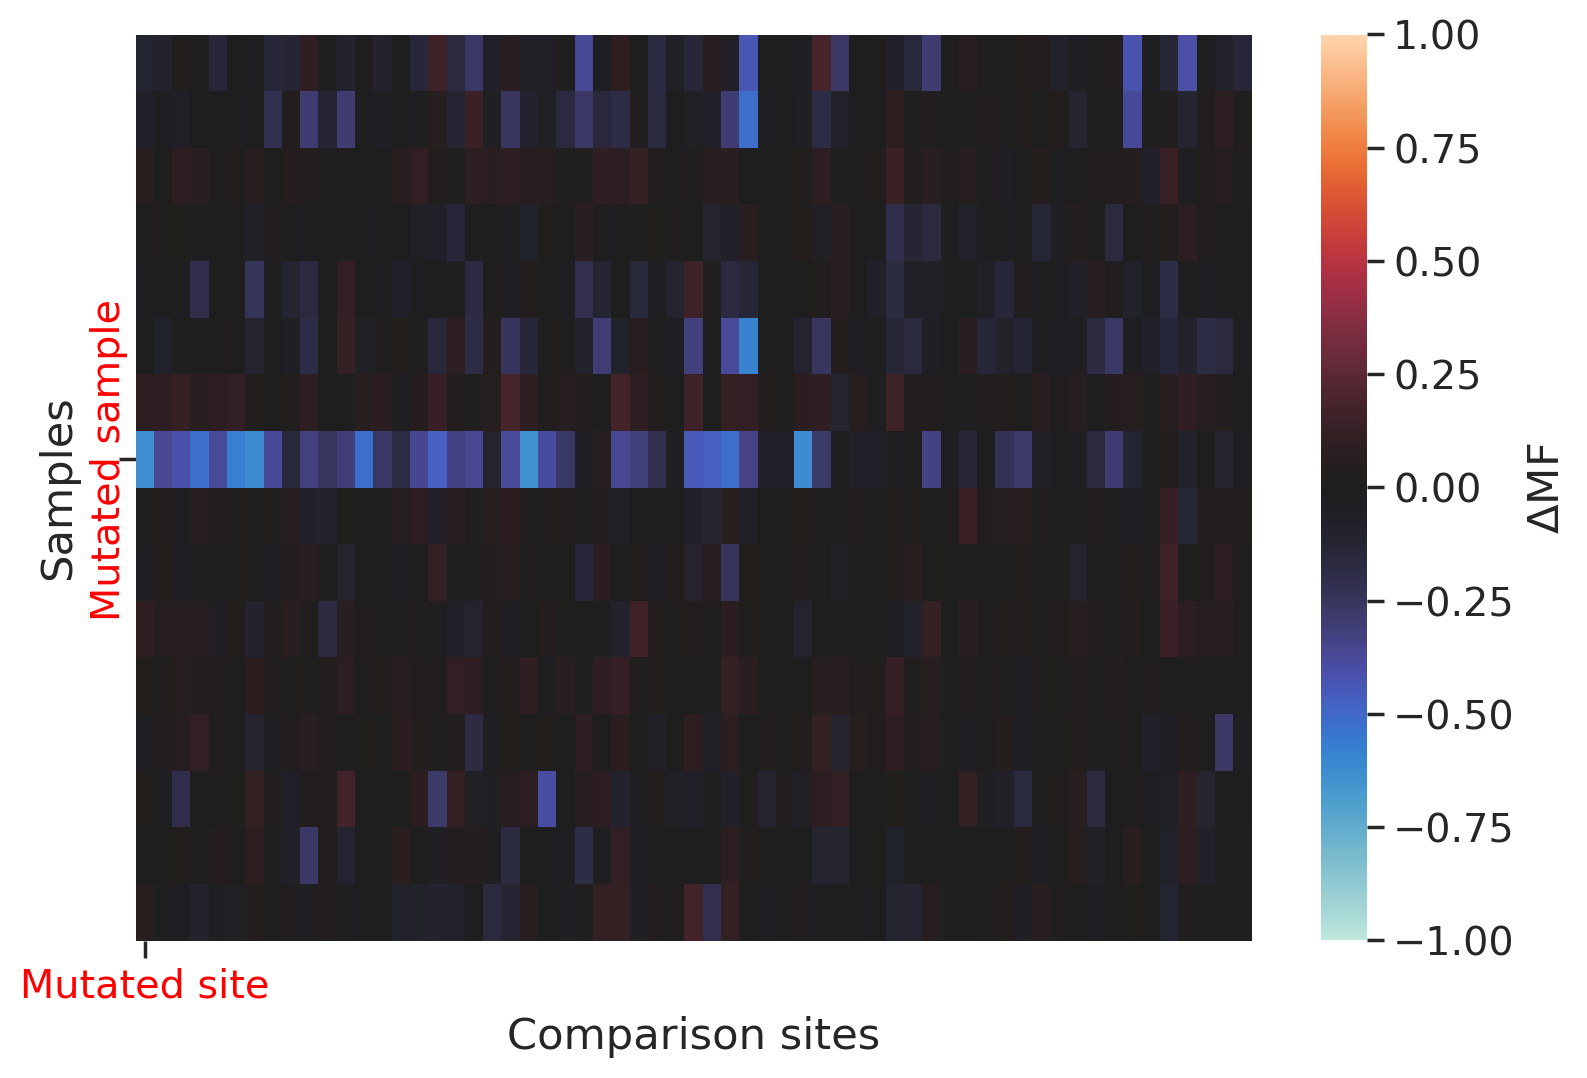

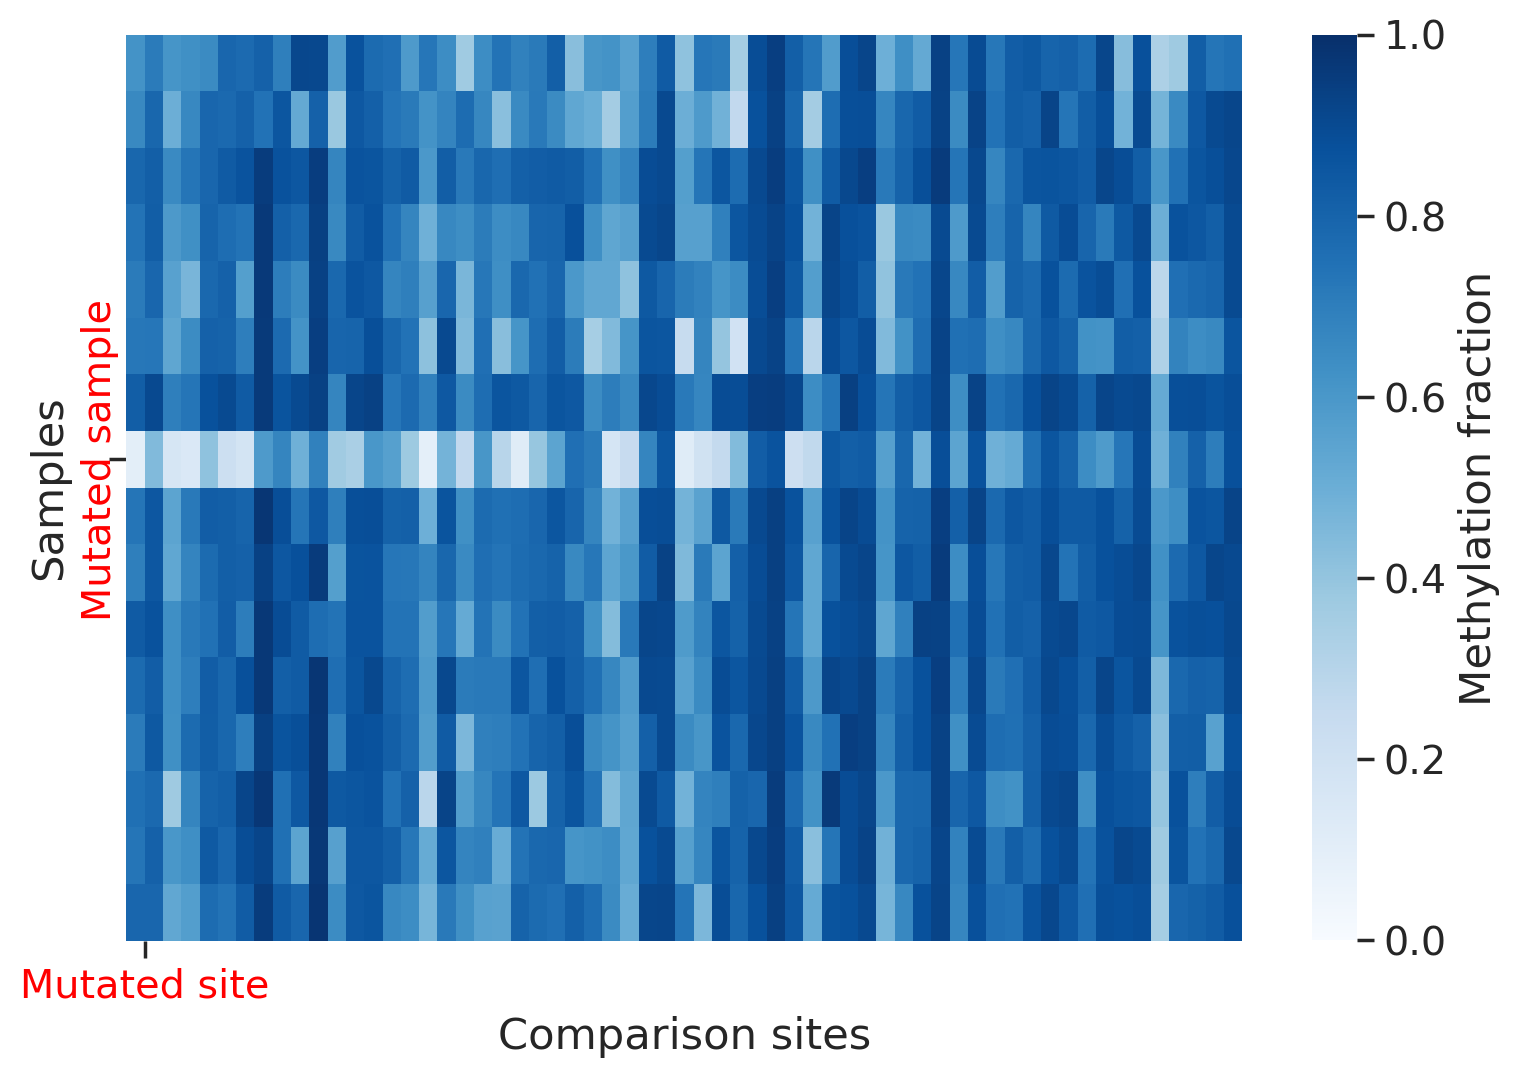

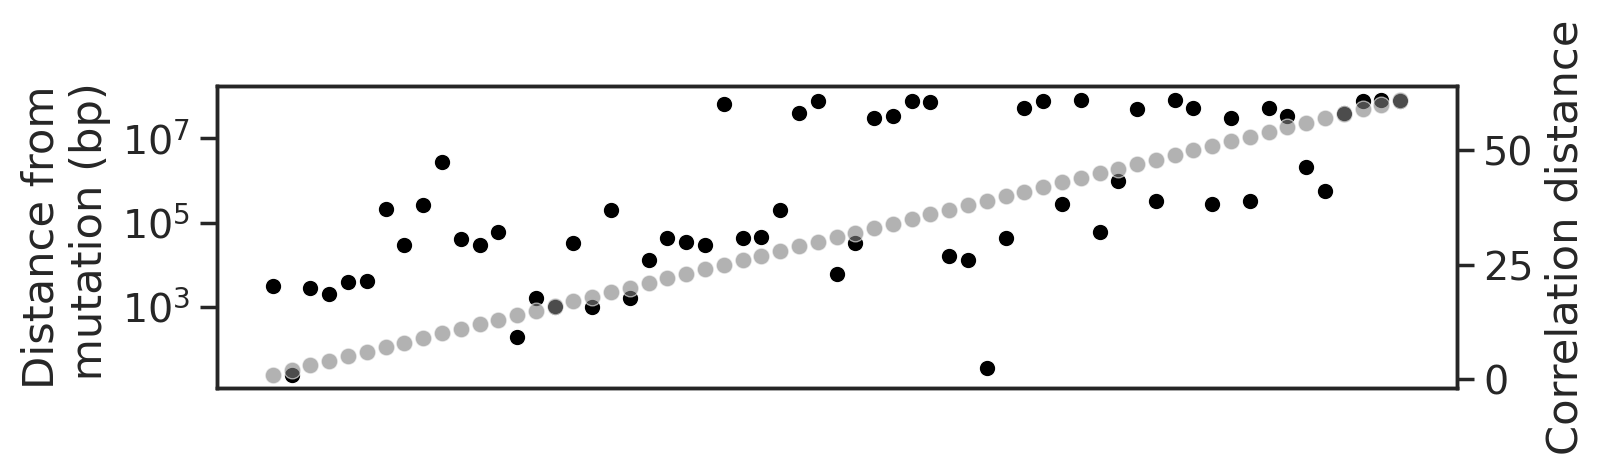

In [251]:
# best:TCGA-AX-A1CE_14:23844900	w/ max_abs_distance = 60 and max_matched_samples = 30
all_samples_comp_sites_dmf, comparison_site_and_distances = analyze_comethylation.plot_heatmap_dist(
    mut_event = corr_supernova_candidates.loc[3, 'mut_event'], comparison_sites_df = corr_all_comparison_site_df,all_methyl_age_df_t = all_methyl_age_df_t, 
    illumina_cpg_locs_df = illumina_cpg_locs_df, method = 'corr',
    max_abs_distance = 60, max_matched_samples = 30  
)

In [222]:
# correlation of distance vs corr dstiacnes and delta_mf
pearsonr(all_samples_comp_sites_dmf.loc['TCGA-AX-A1CE'],comparison_site_and_distances['distances'] )
pearsonr(all_samples_comp_sites_dmf.loc['TCGA-AX-A1CE'], comparison_site_and_distances['actual_distances'].abs() )

(0.30068913829862204, 2.415091544989426e-22)

### IDH1 example

In [19]:
nonQN_methyl_df_t = get_data.get_methylation('/cellar/users/zkoch/methylation_and_mutation/data/processed_methylation').T

Converting Dask df to pandas df, takes ~10min


In [20]:
all_mut_w_age_df['mut_loc'] = all_mut_w_age_df['chr'] + ':' + all_mut_w_age_df['start'].astype(str)

In [184]:
all_mut_w_age_df.loc[
    (all_mut_w_age_df['dataset'] == 'LGG'), 'case_submitter_id'].nunique()

510

/tmp/ipykernel_4074941/2405377726.py:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  has_idh1_mf = nonQN_methyl_df_t.loc[has_idh1].iloc[:, 3:]
/tmp/ipykernel_4074941/2405377726.py:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  no_idh1_mf = nonQN_methyl_df_t.loc[no_idh1].iloc[:, 3:]


<Axes: xlabel='Mean methylome MF', ylabel='Density'>

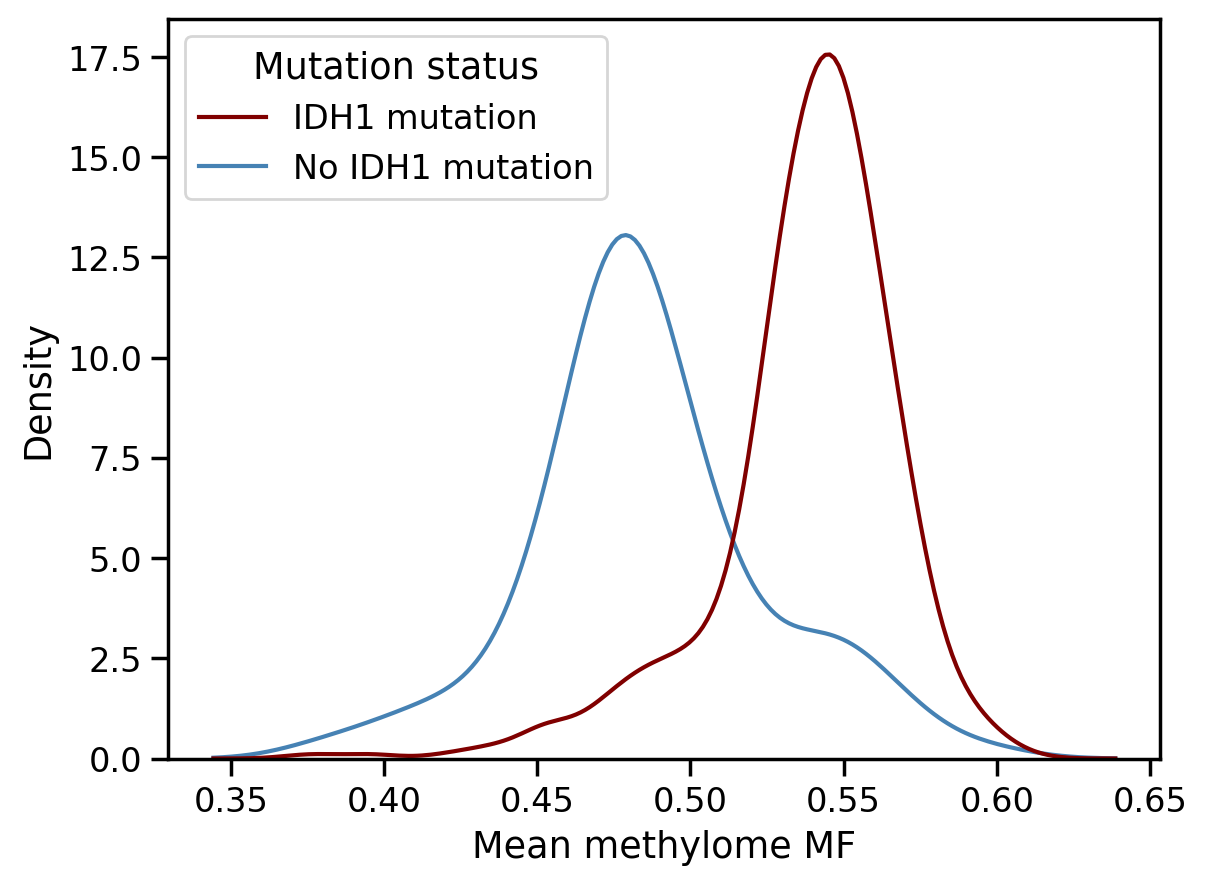

In [92]:
sns.set_context('notebook', font_scale=1.1)
has_idh1 = all_mut_w_age_df.loc[
    (all_mut_w_age_df['dataset'] == 'LGG')
    & (all_mut_w_age_df['mut_loc'] == '2:209113112')
    | ((all_mut_w_age_df['chr'] == '2')
    & (np.abs(all_mut_w_age_df['start'] - 209113112) < 1000)),
    'case_submitter_id'].unique()
no_idh1 = all_mut_w_age_df.loc[
    (all_mut_w_age_df['dataset'] == 'LGG') 
    & ~(all_mut_w_age_df['case_submitter_id'].isin(has_idh1)),
    'case_submitter_id'].unique()
# subset to with methylation
has_idh1 = set(has_idh1).intersection(set(nonQN_methyl_df_t.index))
no_idh1 = set(no_idh1).intersection(set(nonQN_methyl_df_t.index))
has_idh1_mf = nonQN_methyl_df_t.loc[has_idh1].iloc[:, 3:]
has_idh1_mf_mean = has_idh1_mf.mean(axis = 1)
no_idh1_mf = nonQN_methyl_df_t.loc[no_idh1].iloc[:, 3:]
no_idh1_mf_mean = no_idh1_mf.mean(axis = 1)

# mean 
idh1_mf_mean = pd.concat([has_idh1_mf_mean, no_idh1_mf_mean], axis = 0).to_frame()
idh1_mf_mean.columns = ['Mean methylome MF']
idh1_mf_mean['Mutation status'] = ['IDH1 mutation'] * len(has_idh1_mf_mean) + ['No IDH1 mutation'] * len(no_idh1_mf_mean)
sns.kdeplot(
    data = idh1_mf_mean, x = 'Mean methylome MF', hue = 'Mutation status', 
    common_norm = False, common_grid = True, 
    palette=['maroon', 'steelblue' ], cut = 3
    )

In [49]:
# no mean
has_mut_all = has_idh1_mf.to_numpy().flatten()
no_mut_all = no_idh1_mf.to_numpy().flatten()
# concat these 
all_numpy = np.concatenate([has_mut_all, no_mut_all])
# make a df
all_df = pd.DataFrame(all_numpy, columns = ['Methylation fraction'])
all_df['Mutation status'] = ['Has IDH1 mutation'] * len(has_mut_all) + ['No IDH1 mutation'] * len(no_mut_all)

<Axes: xlabel='Methylation fraction', ylabel='Probability'>

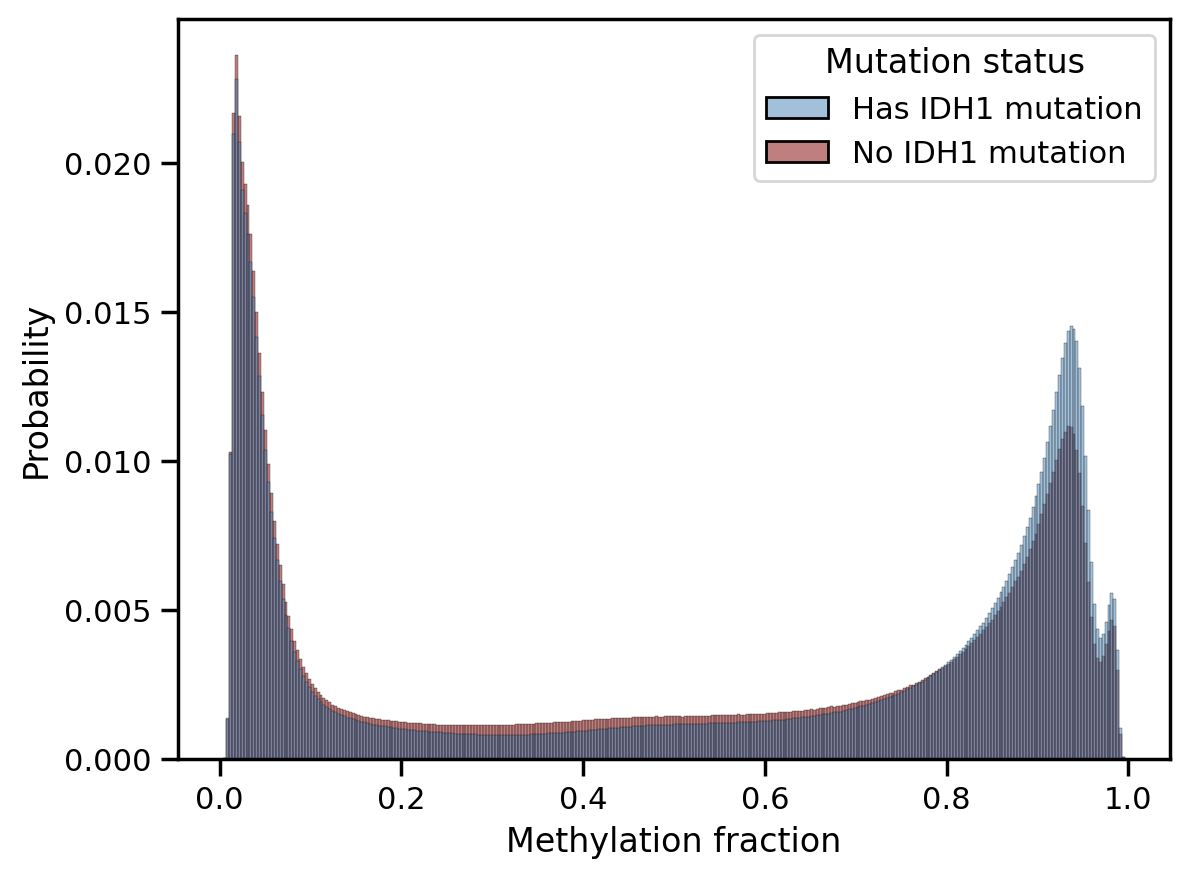

In [53]:
sns.histplot(data = all_df, x = 'Methylation fraction', hue = 'Mutation status', common_norm = False, palette=['steelblue', 'maroon'], stat = 'probability')

<Axes: xlabel='Methylation fraction', ylabel='Probability'>

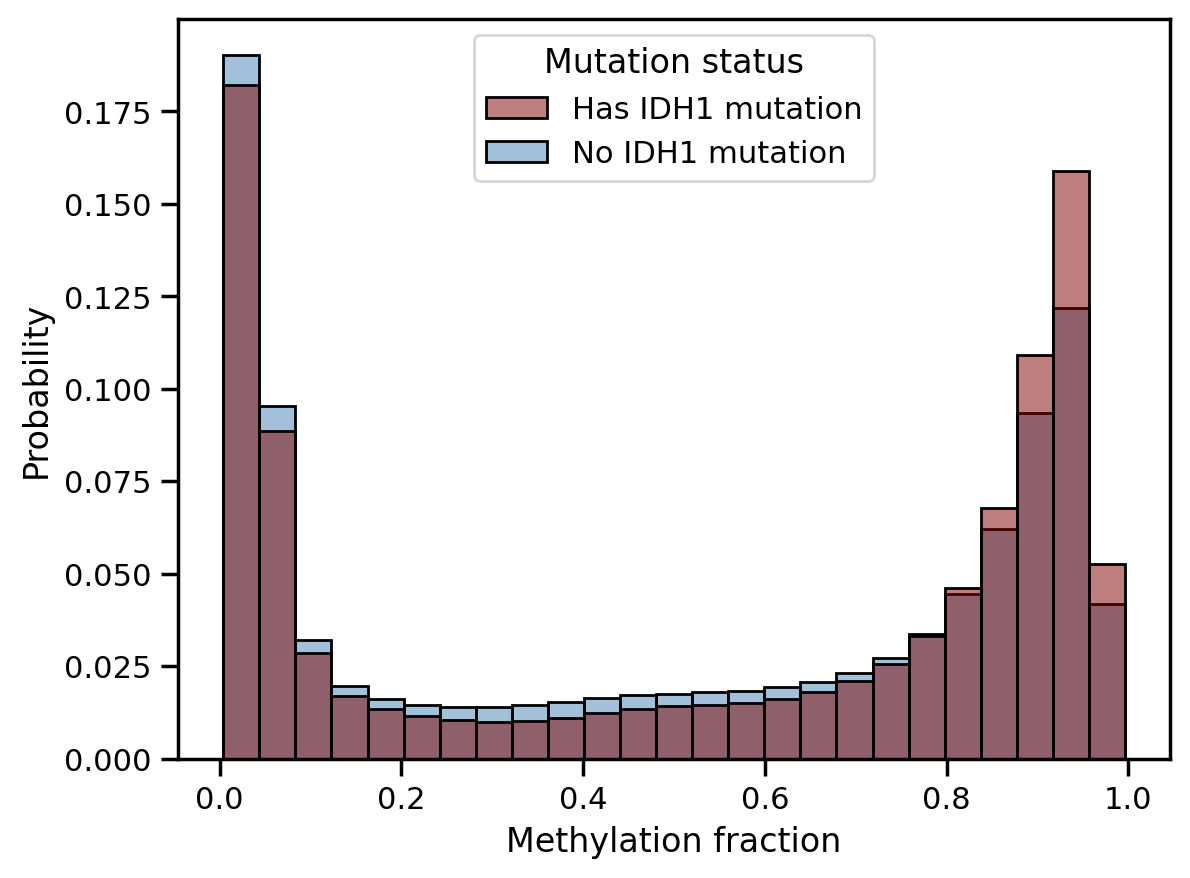

In [55]:
sns.histplot(data = all_df, x = 'Methylation fraction', hue = 'Mutation status', common_norm = False, palette=['maroon', 'steelblue'], stat = 'probability', bins = 25)

### Mut type vs effect

In [150]:
VALID_MUTATIONS = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G", "G>C","G>A", "A>T", "A>G" , "A>C", "G>T", "C>-"]
# read in mutation data
all_mut_all_col_df = pd.read_csv('/cellar/users/zkoch/methylation_and_mutation/data/PANCAN_mut.tsv.gz', sep = '\t')
all_mut_all_col_df['sample'] = all_mut_all_col_df['sample'].str[:-3]
all_mut_all_col_df.rename({'sample': 'case_submitter_id'}, axis = 1, inplace = True)
all_mut_all_col_df["mut_type"] = all_mut_all_col_df["reference"] + '>' + all_mut_all_col_df["alt"]
all_mut_all_col_df = all_mut_all_col_df.loc[all_mut_all_col_df["mut_type"].isin(VALID_MUTATIONS)]
all_mut_all_col_df['mut_event'] = all_mut_all_col_df['case_submitter_id'] + '_' + all_mut_all_col_df['chr'] + ':' + all_mut_all_col_df['start'].astype(str)

# load ref
reference_genome = Fasta('/cellar/users/zkoch/methylation_and_mutation/data/genome_annotations/hg19.fa')
# and cgi 
cpg_islands = pd.read_csv('/cellar/users/zkoch/methylation_and_mutation/data/genome_annotations/CpG_islands_hg19.bed.gz', sep = '\t', header = None)
cpg_islands.columns = ['chr', 'start', 'end', 'name']
cpg_islands['chr'] = cpg_islands['chr'].str.replace('chr', '')

#### Dist

In [159]:
def number_of_mutated_samples(mean_metrics_df):
    return mean_metrics_df.loc[
       ( mean_metrics_df['mutated_sample'] == True)
       & (mean_metrics_df['is_background'] == False)
       & (mean_metrics_df['distance'] == 10000)].shape[0]

In [162]:
number_of_mutated_samples(dist_mean_metrics_df)

1823

In [163]:
# merge with mean metrics 10kb
dist_mean_metrics_w_mut = dist_mean_metrics_df.loc[
        dist_mean_metrics_df['mutated_sample']
        #& (dist_mean_metrics_df['is_background'] == False)
        & (dist_mean_metrics_df['distance'] == 10000)
        ].merge(all_mut_all_col_df, left_on = 'mut_event', right_on = 'mut_event', how = 'left')

# map to combined mutation types
dist_mean_metrics_w_mut['mut_type_combined'] = dist_mean_metrics_w_mut['mut_type'].map({
    'C>A': 'C>A', 'G>T': 'C>A', 
    'C>G': 'C>G', 'G>C': 'C>G', 
    'C>T': 'C>T', 'G>A': 'C>T', 
    'T>A': 'T>A', 'A>T': 'T>A',
    'T>C': 'T>C', 'A>G': 'T>C',
    'T>G': 'T>G', 'A>C': 'T>G'})
# remove deletions
dist_mean_metrics_w_mut = dist_mean_metrics_w_mut.loc[dist_mean_metrics_w_mut['alt'] != '-']
# add chr and start for BG muts
dist_mean_metrics_w_mut['start'] = dist_mean_metrics_w_mut['mut_event'].str.split('_').str[1].str.split(':').str[1].astype(int)
dist_mean_metrics_w_mut['chr'] = dist_mean_metrics_w_mut['mut_event'].str.split('_').str[1].str.split(':').str[0]
# add alt 
dist_mean_metrics_w_mut.loc[dist_mean_metrics_w_mut['is_background'], 'alt'] = 'Z'

# get sequences
# start - 1 get the actual val
dist_mean_metrics_w_mut['seq'] = dist_mean_metrics_w_mut.apply(lambda x: reference_genome['chr'+x['chr']][x['start']-2: x['start'] + 1].seq, axis = 1)
# was or becomes cpg
dist_mean_metrics_w_mut['was_cpg'] = dist_mean_metrics_w_mut['seq'].str.upper().str.contains('CG')
dist_mean_metrics_w_mut['new_seq'] = dist_mean_metrics_w_mut.apply(lambda row: row['seq'][0] + row['alt'] + row['seq'][2], axis = 1)
dist_mean_metrics_w_mut['becomes_cpg'] = dist_mean_metrics_w_mut['new_seq'].str.upper().str.contains('CG')
# is cgi
is_cgi = ((dist_mean_metrics_w_mut['chr'].values[:, np.newaxis] == cpg_islands['chr'].values) &
          (dist_mean_metrics_w_mut['start'].values[:, np.newaxis] >= cpg_islands['start'].values) &
          (dist_mean_metrics_w_mut['start'].values[:, np.newaxis] <= cpg_islands['end'].values)).any(axis=1)
dist_mean_metrics_w_mut['is_cgi'] = is_cgi
# also get sequence in 200bp window around each mutation 
dist_mean_metrics_w_mut['seq_200bp'] = dist_mean_metrics_w_mut.apply(lambda x: reference_genome['chr'+x['chr']][x['start']-101: x['start'] + 100].seq, axis = 1)
# get gc content in 200bp window
dist_mean_metrics_w_mut['gc_perc_200bp'] = (dist_mean_metrics_w_mut['seq_200bp'].str.upper().str.count('G') + dist_mean_metrics_w_mut['seq_200bp'].str.upper().str.count('C')) / 200

pval = 0.09108512939900734 => no signficant differences between mutation classes


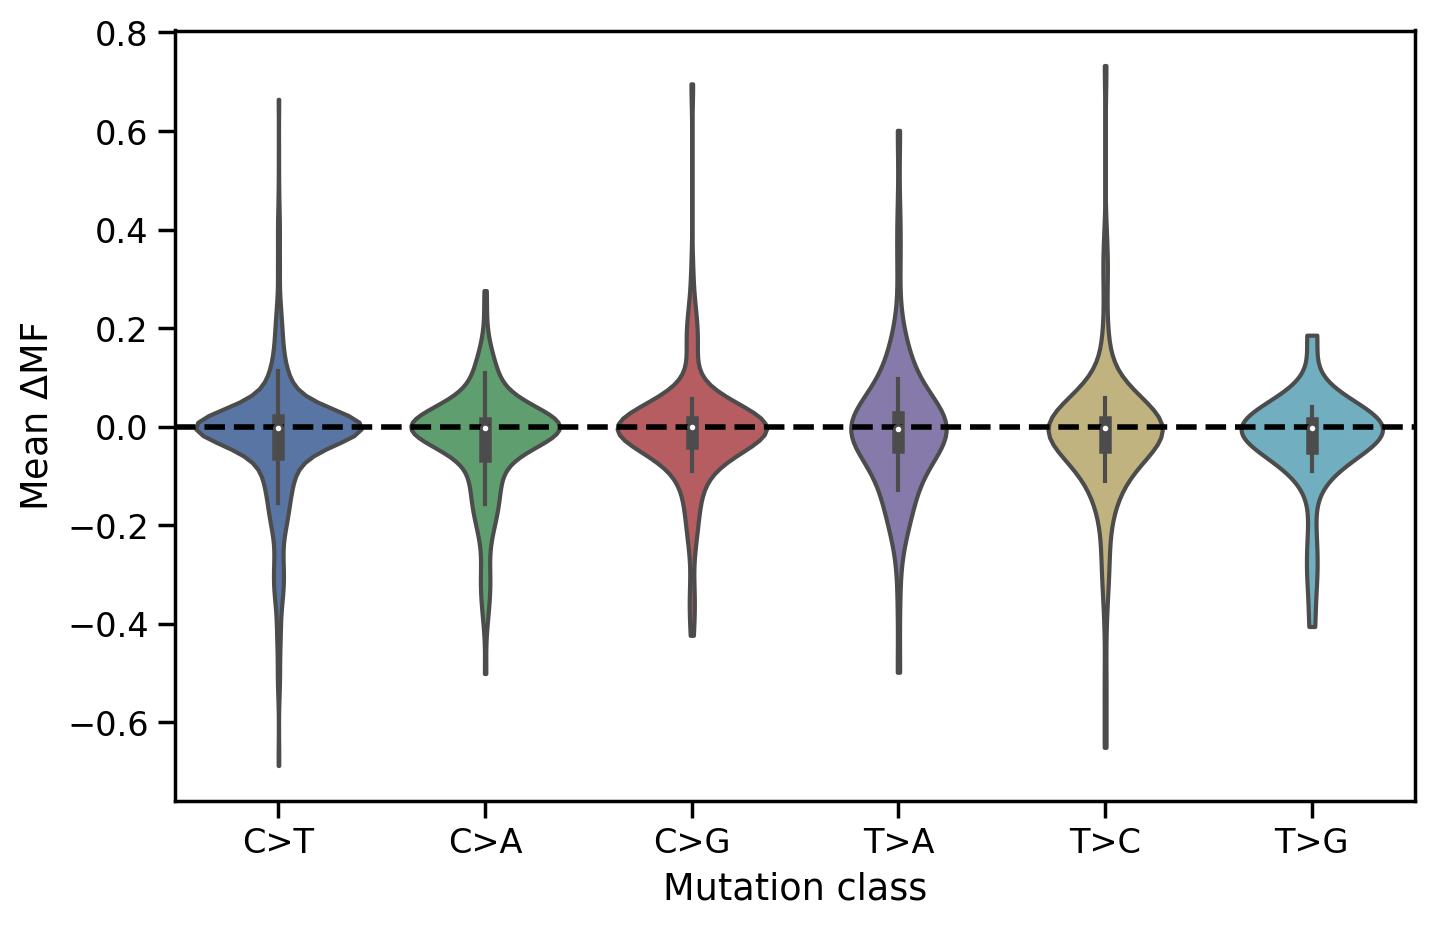

In [191]:
# do anova on mean dmf and mutation type using statsmodels 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.set_context('notebook', font_scale=1.1)
# make two subplots difference sizes
fig, axes = plt.subplots(figsize = (8, 5))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
sns.violinplot(
    data = dist_mean_metrics_w_mut.loc[dist_mean_metrics_w_mut['is_background'] == False],
    x = 'mut_type_combined', y = 'median_dmf', 
    ax = axes, order = ['C>T', 'C>A', 'C>G', 'T>A', 'T>C', 'T>G'],
    cut = 0
)
# plot y= 0
axes.axhline(y = 0, color = 'black', linestyle = '--', linewidth = 2)
axes.set_ylabel(r'Mean $\Delta$MF')
axes.set_xlabel('Mutation class')

g1, g2, g3, g4, g5, g6 = dist_mean_metrics_w_mut.loc[dist_mean_metrics_w_mut['mut_type_combined'] == 'C>A', 'median_dmf'], dist_mean_metrics_w_mut.loc[dist_mean_metrics_w_mut['mut_type_combined'] == 'C>G', 'median_dmf'], dist_mean_metrics_w_mut.loc[dist_mean_metrics_w_mut['mut_type_combined'] == 'C>T', 'median_dmf'], dist_mean_metrics_w_mut.loc[dist_mean_metrics_w_mut['mut_type_combined'] == 'T>A', 'median_dmf'], dist_mean_metrics_w_mut.loc[dist_mean_metrics_w_mut['mut_type_combined'] == 'T>C', 'median_dmf'], dist_mean_metrics_w_mut.loc[dist_mean_metrics_w_mut['mut_type_combined'] == 'T>G', 'median_dmf']
# abs 
g1, g2, g3, g4, g5, g6 = np.abs(g1), np.abs(g2), np.abs(g3), np.abs(g4), np.abs(g5), np.abs(g6)

# dist_mean_metrics_w_mut is already filtered for non-background, mutated samples at distance 5000
# do kruskall wallis test 
from scipy.stats import kruskal
_, p = kruskal( g1 , g2, g3, g4, g5, g6)

import scikit_posthocs 
pvals =  scikit_posthocs.posthoc_dunn([g1, g2, g3, g4, g5, g6], p_adjust = 'fdr_bh')
# name columns and rows 
pvals.columns = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
pvals.index = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
print(f"pval = {p} => no signficant differences between mutation classes")

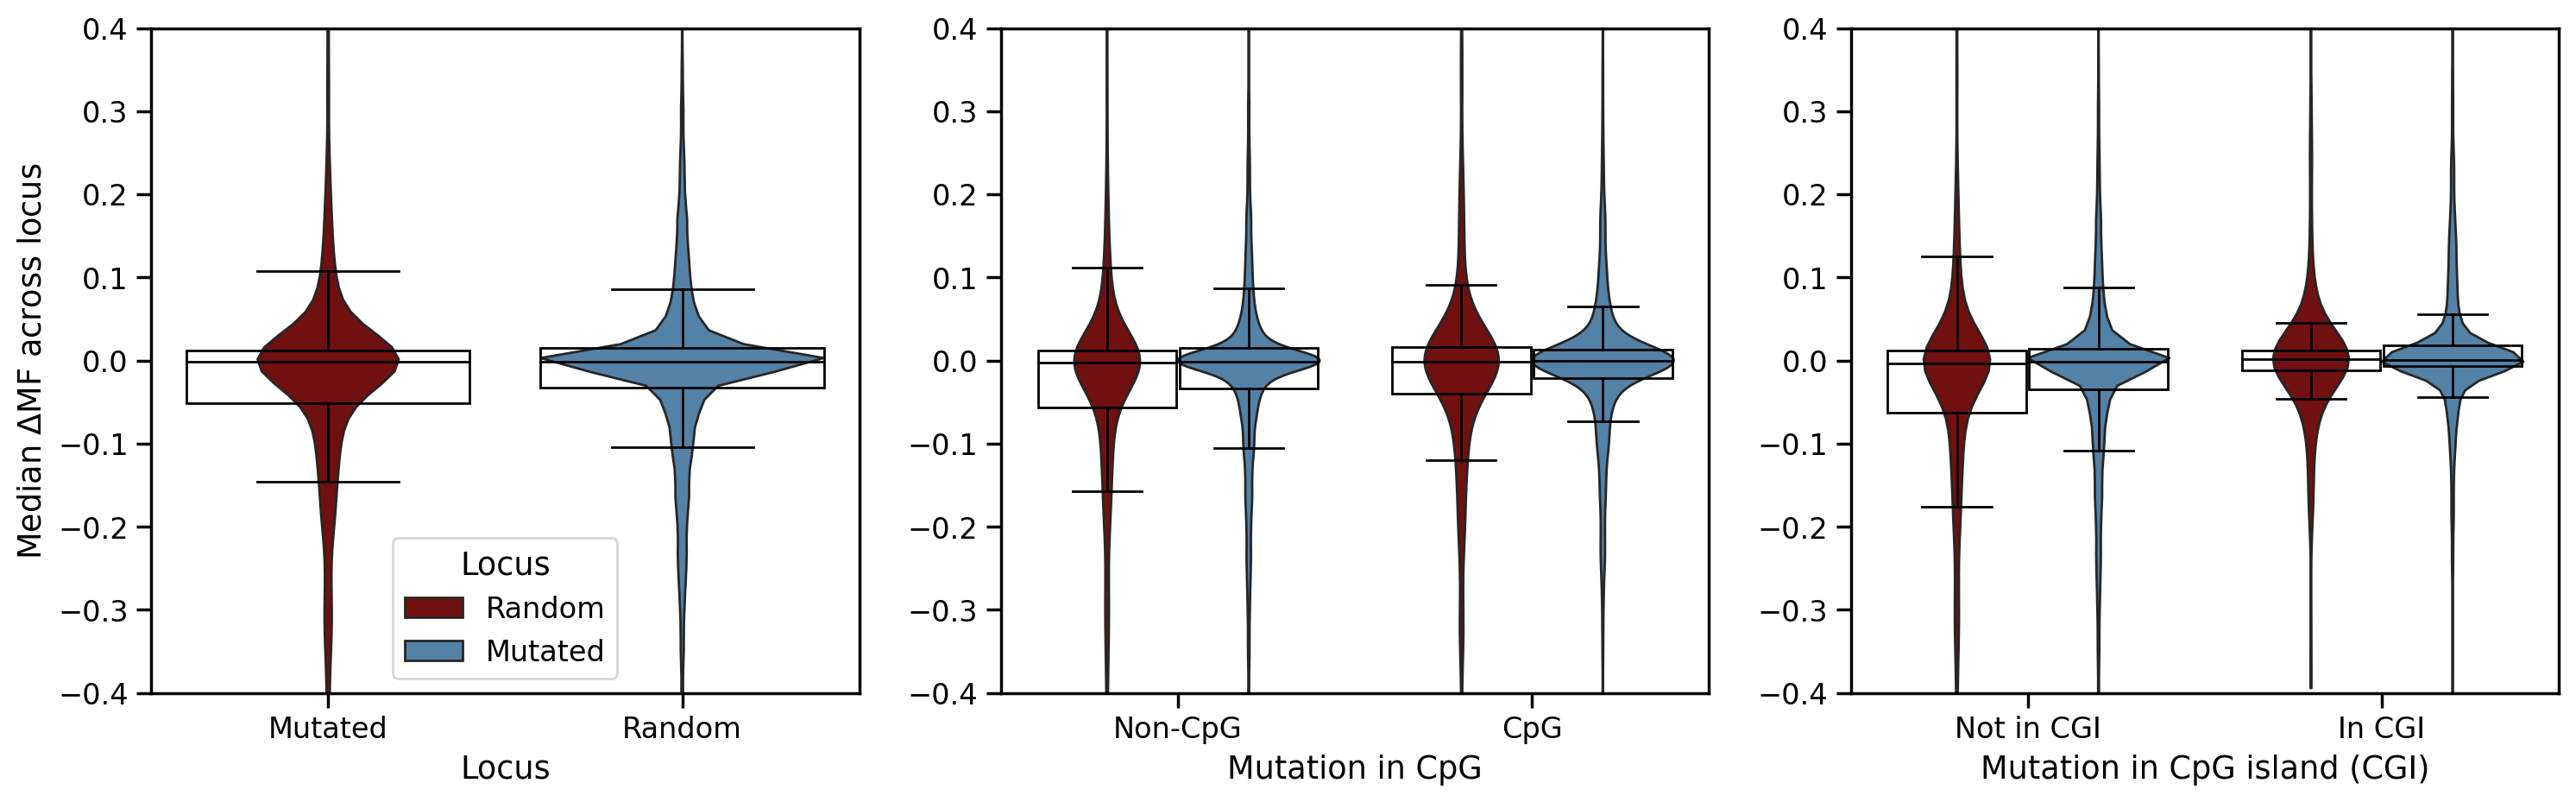

In [176]:
fig, axes = plt.subplots(1, 3, figsize = (18, 5), sharey=True)
###############################################################
# all
###############################################################
# 1000bp non-abs p-value: 0.18280424176399834
# 5kb non-abs p-value: 0.034958923807310076
analyze_comethylation.plot_delta_mf_violin(
    dist_mean_metrics_df.loc[dist_mean_metrics_df['distance'] == 10000],
    metric = 'median_dmf', axes = axes[0]
    )

###############################################################
# CpG vs non-CpG
###############################################################

dist_mean_metrics_w_mut['is_cpg'] = dist_mean_metrics_w_mut['seq'].str.upper().str.contains('CG')
dist_mean_metrics_w_mut['is_cpg'] = dist_mean_metrics_w_mut['is_cpg'].map({True: 'CpG', False: 'Non-CpG'})
sns.violinplot(
    data = dist_mean_metrics_w_mut,
    x = 'is_cpg', y = 'median_dmf', 
    hue = 'is_background', 
    palette= ['maroon', 'steelblue'],
    ax = axes[1], split = False, cut =0, gridsize=1000,
    inner = None, linewidth=0,
)

sns.boxplot(
    data=dist_mean_metrics_w_mut, y='median_dmf', x = 'is_cpg', hue = 'is_background',
    showfliers=False, ax = axes[1], boxprops={"zorder": 2, 'facecolor':'none', 'edgecolor':'black', }, medianprops = {'color':'black'},
    capprops = {'color':'black'}, whiskerprops = {'color':'black'}, zorder = 2, linewidth=1, 
    )
# no legend
axes[1].legend([],[], frameon=False)
# plot y= 0
axes[1].set_ylabel('')
axes[1].set_xlabel('Mutation in CpG')
axes[1].set_ylim(-0.4, 0.4)
axes[1].tick_params(labelleft=True)

    
###############################################################
# CGI vs non-CGI
###############################################################

dist_mean_metrics_w_mut['is_cgi_renamed'] = dist_mean_metrics_w_mut['is_cgi'].map({True: 'In CGI', False: 'Not in CGI'})

sns.violinplot(
    data = dist_mean_metrics_w_mut,
    x = 'is_cgi_renamed', y = 'median_dmf', 
    hue = 'is_background',
    palette= ['maroon', 'steelblue'],
    ax = axes[2], split = False, cut =0,
    inner = None, linewidth=0, legend = False
)

sns.boxplot(
    data=dist_mean_metrics_w_mut, y='median_dmf', x = 'is_cgi_renamed', hue = 'is_background',
    showfliers=False, ax = axes[2], boxprops={"zorder": 2, 'facecolor':'none', 'edgecolor':'black', }, medianprops = {'color':'black'},
    capprops = {'color':'black'}, whiskerprops = {'color':'black'}, zorder = 2, linewidth=1, 
    )
# do not show legend
axes[2].legend([],[], frameon=False)
#axes[2].legend(['Random', 'Mutated'], loc='lower center', title='Locus')
axes[2].set_ylim(-0.4, 0.4)
# plot y= 0
axes[2].set_ylabel('')
axes[2].set_xlabel('Mutation in CpG island (CGI)')
axes[2].tick_params(labelleft=True)

In [167]:
mut = dist_mean_metrics_df.loc[dist_mean_metrics_df.mutated_sample == True]
mut = mut.rename(columns={'is_background': 'Locus'}).replace({'Locus': {True: 'Random', False: 'Mutated'}})
# mann whitney u test for mutated vs not mutated locus
mutated = mut.loc[mut.Locus == 'Mutated', 'median_dmf']
random = mut.loc[mut.Locus == 'Random', 'median_dmf']
u, p = stats.mannwhitneyu(mutated, random, alternative='two-sided')
print(f"p-value: {p}")
print(f"u-statistic: {u}")
print(f"mutated median: {mutated.median()}")
print(f"random median: {random.median()}\n")
# mwu of abs values
print("absolute mwu")
mutated = mut.loc[mut.Locus == 'Mutated', 'median_abs_dmf']
random = mut.loc[mut.Locus == 'Random', 'median_abs_dmf']
u, p = stats.mannwhitneyu(mutated, random, alternative='two-sided')
print(f"p-value: {p}")
print(f"u-statistic: {u}")
print(f"mutated median: {mutated.median()}")
print(f"random median: {random.median()}\n")

p-value: 4.439048944917836e-05
u-statistic: 4480157430.0
mutated median: -0.0005967974366381246
random median: -0.0007310976382454357

absolute mwu
p-value: 4.59189939056868e-07
u-statistic: 4716675133.5
mutated median: 0.043650556352245816
random median: 0.04212901195276708



In [169]:
# do kruskall wallis test for CpG vs non-CpG
from scipy.stats import kruskal
# 4 groups: random cpg, random non-cpg, mutated cpg, mutated non-cpg
g1, g2, g3, g4 = dist_mean_metrics_w_mut.loc[(dist_mean_metrics_w_mut['is_background'] == True) & (dist_mean_metrics_w_mut['is_cpg'] == 'CpG'), 'median_dmf'], dist_mean_metrics_w_mut.loc[(dist_mean_metrics_w_mut['is_background'] == True) & (dist_mean_metrics_w_mut['is_cpg'] == 'Non-CpG'), 'median_dmf'], dist_mean_metrics_w_mut.loc[(dist_mean_metrics_w_mut['is_background'] == False) & (dist_mean_metrics_w_mut['is_cpg'] == 'CpG'), 'median_dmf'], dist_mean_metrics_w_mut.loc[(dist_mean_metrics_w_mut['is_background'] == False) & (dist_mean_metrics_w_mut['is_cpg'] == 'Non-CpG'), 'median_dmf']
# take abs 
g1, g2, g3, g4 = np.abs(g1), np.abs(g2), np.abs(g3), np.abs(g4)
_, p = kruskal(g1, g2, g3, g4)
if p < 0.05:
    import scikit_posthocs 
    pvals =  scikit_posthocs.posthoc_dunn([g1, g2, g3, g4], p_adjust = 'fdr_bh')
    # name columns and rows 
    pvals.columns = ['random CpG', 'random Non-CpG', 'mutated CpG', 'mutated Non-CpG']
    pvals.index = ['random CpG', 'random Non-CpG', 'mutated CpG', 'mutated Non-CpG']
print(pvals)

                   random CpG  random Non-CpG  mutated CpG  mutated Non-CpG
random CpG       1.000000e+00    1.049148e-26     0.000462     7.102421e-18
random Non-CpG   1.049148e-26    1.000000e+00     0.311236     1.153210e-05
mutated CpG      4.623737e-04    3.112357e-01     1.000000     2.502968e-01
mutated Non-CpG  7.102421e-18    1.153210e-05     0.250297     1.000000e+00


In [210]:
# do kruskall wallis test for CGI vs non-CGI
g1, g2, g3, g4 = dist_mean_metrics_w_mut.loc[(dist_mean_metrics_w_mut['is_background'] == True) & (dist_mean_metrics_w_mut['is_cgi']), 'median_dmf'], dist_mean_metrics_w_mut.loc[(dist_mean_metrics_w_mut['is_background'] == True) & (dist_mean_metrics_w_mut['is_cgi'] == False), 'median_dmf'], dist_mean_metrics_w_mut.loc[(dist_mean_metrics_w_mut['is_background'] == False) & (dist_mean_metrics_w_mut['is_cgi']), 'median_dmf'], dist_mean_metrics_w_mut.loc[(dist_mean_metrics_w_mut['is_background'] == False) & (dist_mean_metrics_w_mut['is_cgi'] == False), 'median_dmf']
# take abs
g1, g2, g3, g4 = np.abs(g1), np.abs(g2), np.abs(g3), np.abs(g4)

_, p = kruskal(g1, g2, g3, g4)
if p < .05:
    import scikit_posthocs 
    pvals =  scikit_posthocs.posthoc_dunn([g1, g2, g3, g4], p_adjust = 'fdr_bh')
    # name columns and rows 
    pvals.columns = ['random CGI', 'random Non-CGI', 'mutated CGI', 'mutated Non-CGI']
    pvals.index = ['random CGI', 'random Non-CGI', 'mutated CGI', 'mutated Non-CGI']   
print(pvals)

                    random CGI  random Non-CGI   mutated CGI  mutated Non-CGI
random CGI        1.000000e+00   8.854848e-118  3.275357e-01     7.085913e-56
random Non-CGI   8.854848e-118    1.000000e+00  2.457495e-04     2.788352e-09
mutated CGI       3.275357e-01    2.457495e-04  1.000000e+00     1.357716e-08
mutated Non-CGI   7.085913e-56    2.788352e-09  1.357716e-08     1.000000e+00


PearsonRResult(statistic=-0.11575218677548077, pvalue=7.316147301089482e-07)
SignificanceResult(statistic=-0.14121480647968088, pvalue=1.427935628292428e-09)


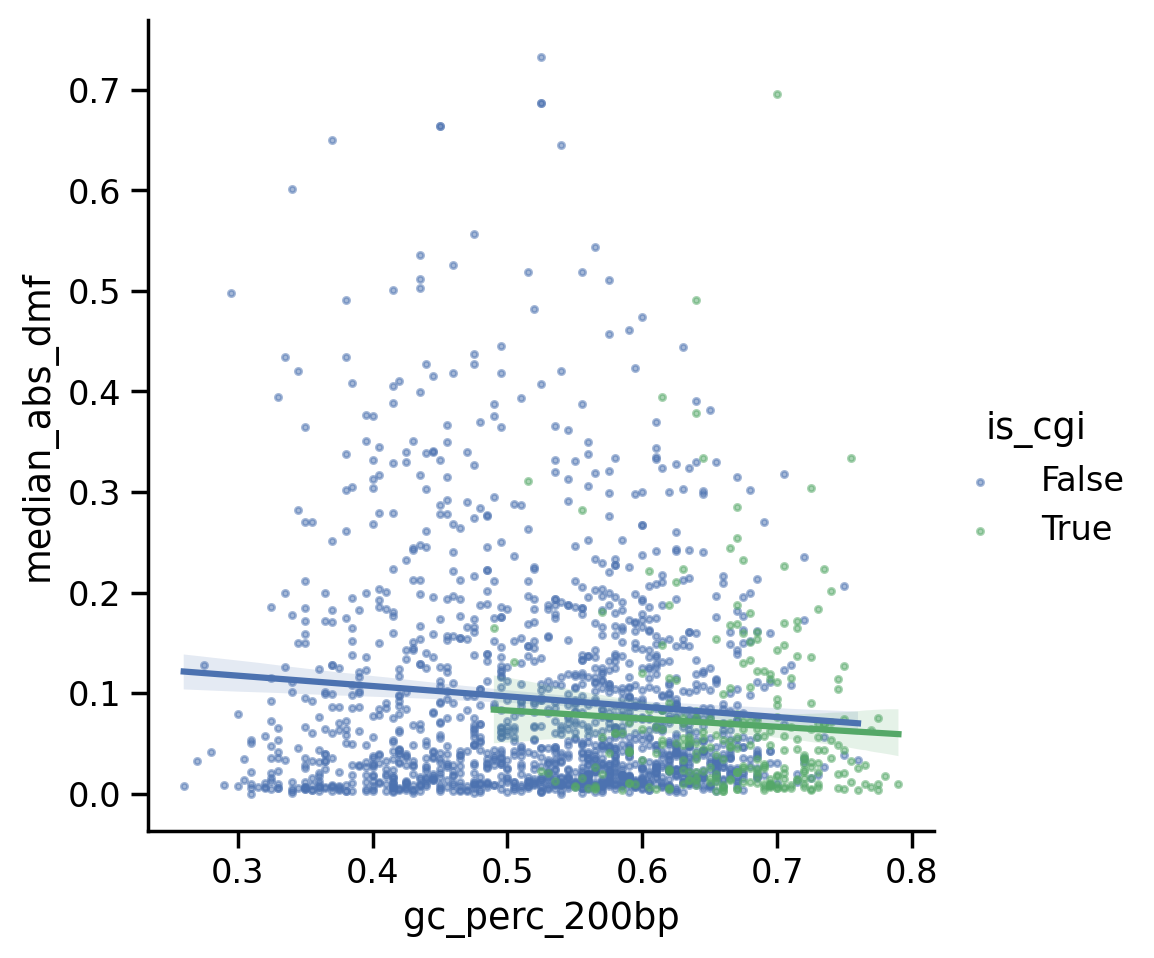

In [208]:
# supplemental
sns.lmplot(x='gc_perc_200bp', y='median_abs_dmf', data=dist_mean_metrics_w_mut.loc[ (dist_mean_metrics_w_mut['is_background'] == False) & (dist_mean_metrics_w_mut['mutated_sample'] == True)], hue='is_cgi', fit_reg=True,  scatter_kws={'s': 5, 'alpha': 0.5})
print(pearsonr(dist_mean_metrics_w_mut.loc[ (dist_mean_metrics_w_mut['is_background'] == False) & (dist_mean_metrics_w_mut['mutated_sample'] == True), 'gc_perc_200bp'], dist_mean_metrics_w_mut.loc[ (dist_mean_metrics_w_mut['is_background'] == False) & (dist_mean_metrics_w_mut['mutated_sample'] == True), 'median_abs_dmf']))
print(spearmanr(dist_mean_metrics_w_mut.loc[ (dist_mean_metrics_w_mut['is_background'] == False) & (dist_mean_metrics_w_mut['mutated_sample'] == True), 'gc_perc_200bp'], dist_mean_metrics_w_mut.loc[ (dist_mean_metrics_w_mut['is_background'] == False) & (dist_mean_metrics_w_mut['mutated_sample'] == True), 'median_abs_dmf']))


#### Corr

In [458]:
corr_mean_metrics_df.loc[
       ( corr_mean_metrics_df['mutated_sample'] == True)
       & (corr_mean_metrics_df['is_background'] == False)
       & (corr_mean_metrics_df['distance'] == 10)].shape[0]

335

In [460]:
corr_mean_metrics_w_mut = corr_mean_metrics_df.loc[
        (corr_mean_metrics_df['mutated_sample'] == True)
        & (corr_mean_metrics_df['is_background'] == False)
        & (corr_mean_metrics_df['distance'] == 10)
        ].merge(all_mut_all_col_df, left_on = 'mut_event', right_on = 'mut_event', how = 'left')

In [463]:
corr_mean_metrics_w_mut.loc[
       ( corr_mean_metrics_w_mut['mutated_sample'] == True)
       & (corr_mean_metrics_w_mut['is_background'] == False)
       & (corr_mean_metrics_w_mut['distance'] == 10)].shape[0]

3

In [468]:
# merge with mean metrics 10kb
corr_mean_metrics_w_mut = corr_mean_metrics_df.loc[
        corr_mean_metrics_df['mutated_sample']
        #& (corr_mean_metrics_df['is_background'] == False)
        & (corr_mean_metrics_df['distance'] == 10)
        ].merge(all_mut_all_col_df, left_on = 'mut_event', right_on = 'mut_event', how = 'left')

# map to combined mutation types
corr_mean_metrics_w_mut['mut_type_combined'] = corr_mean_metrics_w_mut['mut_type'].map({
    'C>A': 'C>A', 'G>T': 'C>A', 
    'C>G': 'C>G', 'G>C': 'C>G', 
    'C>T': 'C>T', 'G>A': 'C>T', 
    'T>A': 'T>A', 'A>T': 'T>A',
    'T>C': 'T>C', 'A>G': 'T>C',
    'T>G': 'T>G', 'A>C': 'T>G'})
# remove deletions
corr_mean_metrics_w_mut = corr_mean_metrics_w_mut.loc[corr_mean_metrics_w_mut['alt'] != '-']
# add chr and start for BG muts
corr_mean_metrics_w_mut['start'] = corr_mean_metrics_w_mut['mut_event'].str.split('_').str[1].str.split(':').str[1].astype(int)
corr_mean_metrics_w_mut['chr'] = corr_mean_metrics_w_mut['mut_event'].str.split('_').str[1].str.split(':').str[0]
# add alt 
corr_mean_metrics_w_mut.loc[corr_mean_metrics_w_mut['is_background'], 'alt'] = 'Z'

# get sequences
# start - 1 get the actual val
corr_mean_metrics_w_mut['seq'] = corr_mean_metrics_w_mut.apply(lambda x: reference_genome['chr'+x['chr']][x['start']-2: x['start'] + 1].seq, axis = 1)
# was or becomes cpg
corr_mean_metrics_w_mut['was_cpg'] = corr_mean_metrics_w_mut['seq'].str.upper().str.contains('CG')
corr_mean_metrics_w_mut['new_seq'] = corr_mean_metrics_w_mut.apply(lambda row: row['seq'][0] + row['alt'] + row['seq'][2], axis = 1)
corr_mean_metrics_w_mut['becomes_cpg'] = corr_mean_metrics_w_mut['new_seq'].str.upper().str.contains('CG')
# is cgi
is_cgi = ((corr_mean_metrics_w_mut['chr'].values[:, np.newaxis] == cpg_islands['chr'].values) &
          (corr_mean_metrics_w_mut['start'].values[:, np.newaxis] >= cpg_islands['start'].values) &
          (corr_mean_metrics_w_mut['start'].values[:, np.newaxis] <= cpg_islands['end'].values)).any(axis=1)
corr_mean_metrics_w_mut['is_cgi'] = is_cgi
# also get sequence in 200bp window around each mutation 
corr_mean_metrics_w_mut['seq_200bp'] = corr_mean_metrics_w_mut.apply(lambda x: reference_genome['chr'+x['chr']][x['start']-101: x['start'] + 100].seq, axis = 1)
# get gc content in 200bp window
corr_mean_metrics_w_mut['gc_perc_200bp'] = (corr_mean_metrics_w_mut['seq_200bp'].str.upper().str.count('G') + corr_mean_metrics_w_mut['seq_200bp'].str.upper().str.count('C')) / 200

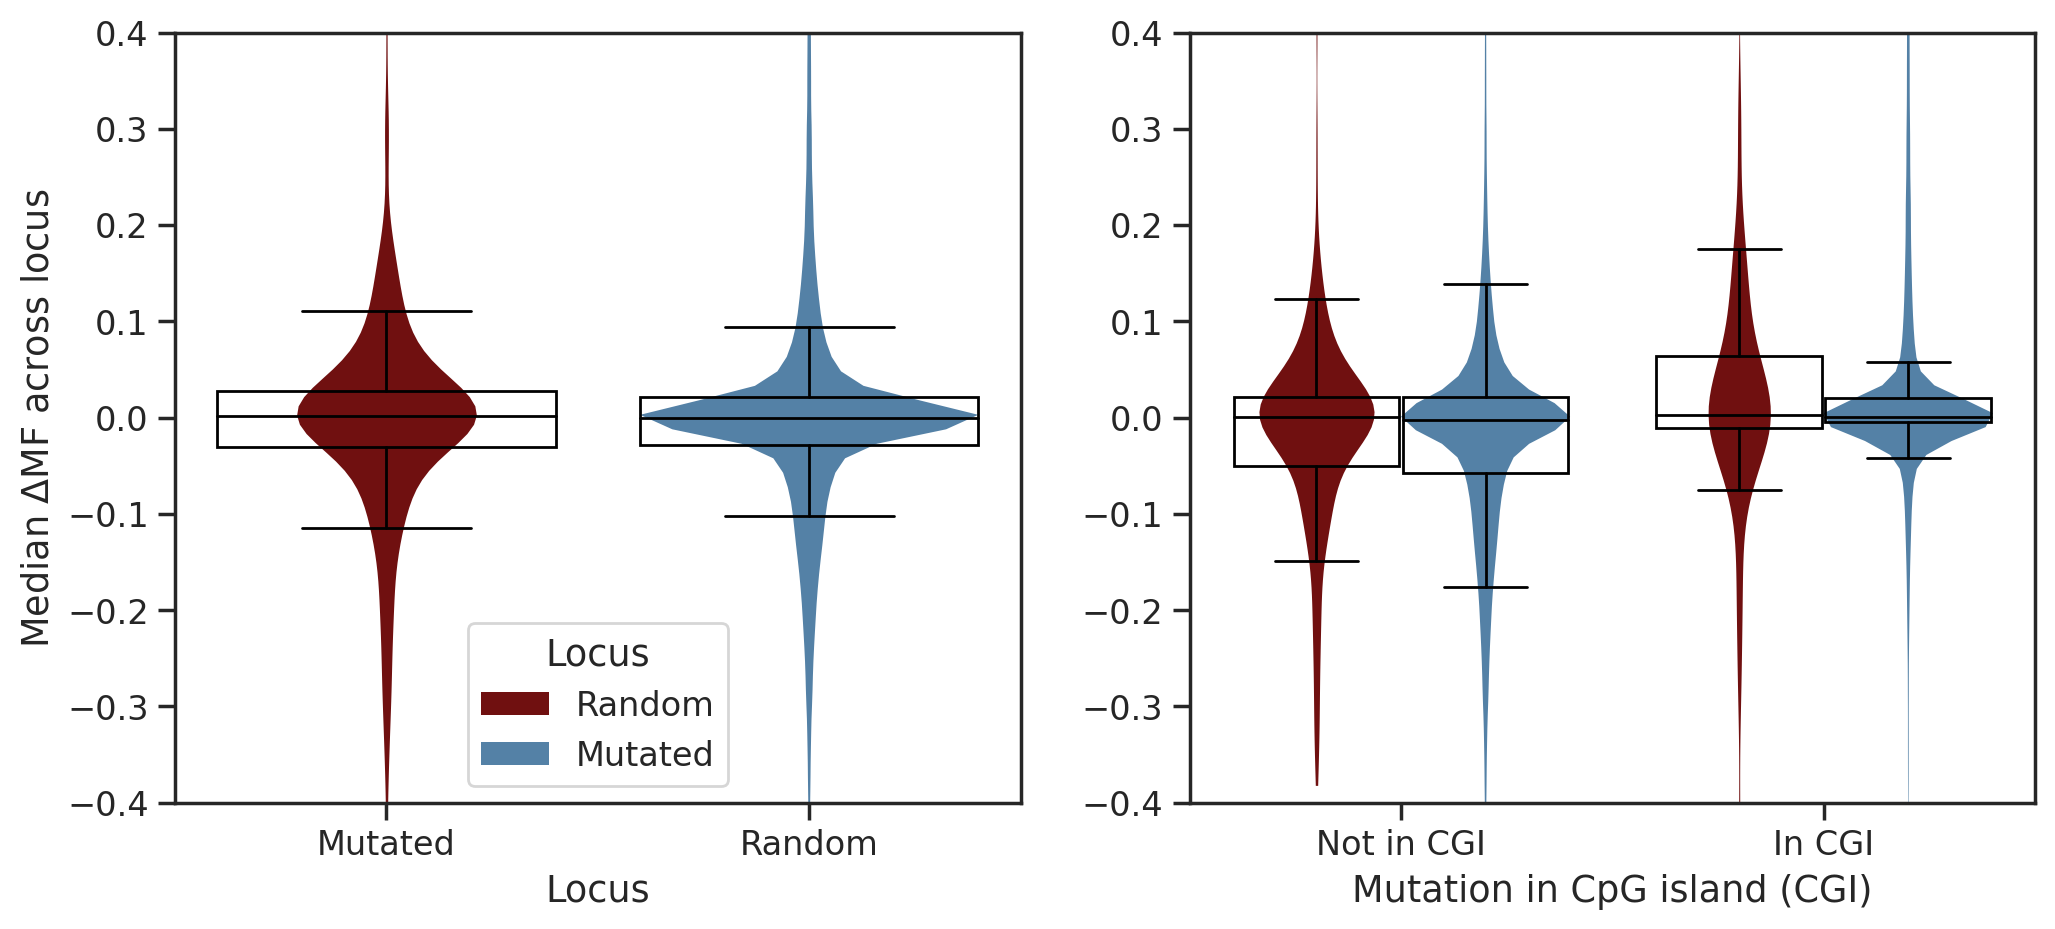

In [481]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5), sharey=True)
###############################################################
# all
###############################################################
# 1000bp non-abs p-value: 0.18280424176399834
# 5kb non-abs p-value: 0.034958923807310076
analyze_comethylation.plot_delta_mf_violin(
    corr_mean_metrics_df.loc[corr_mean_metrics_df['distance'] == 10],
    metric = 'median_dmf', axes = axes[0]
    )


###############################################################
corr_mean_metrics_w_mut['is_cgi_renamed'] = corr_mean_metrics_w_mut['is_cgi'].map({True: 'In CGI', False: 'Not in CGI'})

sns.violinplot(
    data = corr_mean_metrics_w_mut,
    x = 'is_cgi_renamed', y = 'median_dmf', 
    hue = 'is_background',
    palette= ['maroon', 'steelblue'],
    ax = axes[1], split = False, cut =0,
    inner = None, linewidth=0, legend = False
)

sns.boxplot(
    data=corr_mean_metrics_w_mut, y='median_dmf', x = 'is_cgi_renamed', hue = 'is_background',
    showfliers=False, ax = axes[1], boxprops={"zorder": 2, 'facecolor':'none', 'edgecolor':'black', }, medianprops = {'color':'black'},
    capprops = {'color':'black'}, whiskerprops = {'color':'black'}, zorder = 2, linewidth=1, 
    )
# do not show legend
axes[1].legend([],[], frameon=False)
#axes[2].legend(['Random', 'Mutated'], loc='lower center', title='Locus')
axes[1].set_ylim(-0.4, 0.4)
# plot y= 0
axes[1].set_ylabel('')
axes[1].set_xlabel('Mutation in CpG island (CGI)')
axes[1].tick_params(labelleft=True)

In [475]:
mut = corr_mean_metrics_df.loc[corr_mean_metrics_df.mutated_sample == True]
mut = mut.rename(columns={'is_background': 'Locus'}).replace({'Locus': {True: 'Random', False: 'Mutated'}})
# mann whitney u test for mutated vs not mutated locus
mutated = mut.loc[mut.Locus == 'Mutated', 'median_dmf']
random = mut.loc[mut.Locus == 'Random', 'median_dmf']
u, p = stats.mannwhitneyu(mutated, random, alternative='two-sided')
print(f"p-value: {p}")
print(f"u-statistic: {u}")
print(f"mutated median: {mutated.median()}")
print(f"random median: {random.median()}\n")
# mwu of abs values
print("absolute mwu")
mutated = mut.loc[mut.Locus == 'Mutated', 'median_abs_dmf']
random = mut.loc[mut.Locus == 'Random', 'median_abs_dmf']
u, p = stats.mannwhitneyu(mutated, random, alternative='two-sided')
print(f"p-value: {p}")
print(f"u-statistic: {u}")
print(f"mutated median: {mutated.median()}")
print(f"random median: {random.median()}\n")

p-value: 0.04878307584305241
u-statistic: 278737319.5
mutated median: 0.00023109331797127597
random median: -0.000620151976238516

absolute mwu
p-value: 0.00017804413111752507
u-statistic: 284983392.0
mutated median: 0.05046154959677296
random median: 0.049996118692395425



In [476]:
# do kruskall wallis test for CGI vs non-CGI
g1, g2, g3, g4 = corr_mean_metrics_w_mut.loc[(corr_mean_metrics_w_mut['is_background'] == True) & (corr_mean_metrics_w_mut['is_cgi']), 'median_dmf'], corr_mean_metrics_w_mut.loc[(corr_mean_metrics_w_mut['is_background'] == True) & (corr_mean_metrics_w_mut['is_cgi'] == False), 'median_dmf'], corr_mean_metrics_w_mut.loc[(corr_mean_metrics_w_mut['is_background'] == False) & (corr_mean_metrics_w_mut['is_cgi']), 'median_dmf'], corr_mean_metrics_w_mut.loc[(corr_mean_metrics_w_mut['is_background'] == False) & (corr_mean_metrics_w_mut['is_cgi'] == False), 'median_dmf']
# take abs
g1, g2, g3, g4 = np.abs(g1), np.abs(g2), np.abs(g3), np.abs(g4)

_, p = kruskal(g1, g2, g3, g4)
if p < .05:
    import scikit_posthocs 
    pvals =  scikit_posthocs.posthoc_dunn([g1, g2, g3, g4], p_adjust = 'fdr_bh')
    # name columns and rows 
    pvals.columns = ['random CGI', 'random Non-CGI', 'mutated CGI', 'mutated Non-CGI']
    pvals.index = ['random CGI', 'random Non-CGI', 'mutated CGI', 'mutated Non-CGI']   
print(pvals)

                   random CGI  random Non-CGI  mutated CGI  mutated Non-CGI
random CGI       1.000000e+00        0.000000     0.000134     8.716909e-11
random Non-CGI   0.000000e+00        1.000000     0.496863     4.968630e-01
mutated CGI      1.336626e-04        0.496863     1.000000     8.350620e-01
mutated Non-CGI  8.716909e-11        0.496863     0.835062     1.000000e+00


### ucsc annotation

In [407]:
from ucsc.api import Hub, Genome, Track, TrackSchema, Chromosome, Sequence  


In [418]:
genome = Genome.find('hg19') 

genome found


In [427]:
gene_track = genome.findTrack('ensGene')

In [440]:
gene_track.buildList()

AttributeError: 'Track' object has no attribute 'buildList'

In [428]:
cgi_track = genome.findTrackBy('shortLabel','CpG Islands')

track found


In [426]:
dnase_track = genome.findTrackBy('shortLabel','Master DNaseI HS')

track found


In [433]:
track = Track.find('hg38', 'Master DNaseI HS')  # or you can get the track using the findBy method

Exception: can't find track, Track does not exist

In [438]:
track = Track.find('hg38', 'knownGene')  # or you can get the track using the findBy method
Track.getTrackData(genome='hg38', maxItemsOutput=100)


AttributeError: type object 'Track' has no attribute 'getTrackData'

In [434]:
dnase_track.getTrackData(genome='hg19', chrom='chr1', start=47000, end=48000)

AttributeError: 'Track' object has no attribute 'getTrackData'

#### Corr

In [64]:
# merge with mean metrics 5kb
corr_mean_metrics_w_mut = corr_mean_metrics_df.loc[
        corr_mean_metrics_df['mutated_sample']
        & (corr_mean_metrics_df['is_background'] == False)
        & (corr_mean_metrics_df['distance'] == 10)
        ].merge(all_mut_all_col_df, left_on = 'mut_event', right_on = 'mut_event', how = 'left')

# map to combined mutation types
corr_mean_metrics_w_mut['mut_type_combined'] = corr_mean_metrics_w_mut['mut_type'].map({
    'C>A': 'C>A', 'G>T': 'C>A', 
    'C>G': 'C>G', 'G>C': 'C>G', 
    'C>T': 'C>T', 'G>A': 'C>T', 
    'T>A': 'T>A', 'A>T': 'T>A',
    'T>C': 'T>C', 'A>G': 'T>C',
    'T>G': 'T>G', 'A>C': 'T>G'})
# remove deletions
corr_mean_metrics_w_mut = corr_mean_metrics_w_mut.loc[corr_mean_metrics_w_mut['alt'] != '-']
# add chr and start for BG muts
"""dist_mean_metrics_w_mut['start'] = dist_mean_metrics_w_mut['mut_event'].str.split('_').str[1].str.split(':').str[1].astype(int)
dist_mean_metrics_w_mut['chr'] = dist_mean_metrics_w_mut['mut_event'].str.split('_').str[1].str.split(':').str[0]
# add alt 
dist_mean_metrics_w_mut.loc[dist_mean_metrics_w_mut['is_background'], 'alt'] = 'Z'"""

# get sequences
# start - 1 get the actual val
corr_mean_metrics_w_mut['seq'] = corr_mean_metrics_w_mut.apply(lambda x: reference_genome['chr'+x['chr']][x['start']-2: x['start'] + 1].seq, axis = 1)
# was or becomes cpg
corr_mean_metrics_w_mut['was_cpg'] = corr_mean_metrics_w_mut['seq'].str.upper().str.contains('CG')
corr_mean_metrics_w_mut['new_seq'] = corr_mean_metrics_w_mut.apply(lambda row: row['seq'][0] + row['alt'] + row['seq'][2], axis = 1)
corr_mean_metrics_w_mut['becomes_cpg'] = corr_mean_metrics_w_mut['new_seq'].str.upper().str.contains('CG')
# is cgi
corr_mean_metrics_w_mut['is_cgi'] = corr_mean_metrics_w_mut.apply(lambda row: (row['chr'] == cpg_islands['chr']) & (row['start'] >= cpg_islands['start']) & (row['start'] <= cpg_islands['end']), axis = 1).any(axis = 1)


Text(0.5, 0, 'In CpG island')

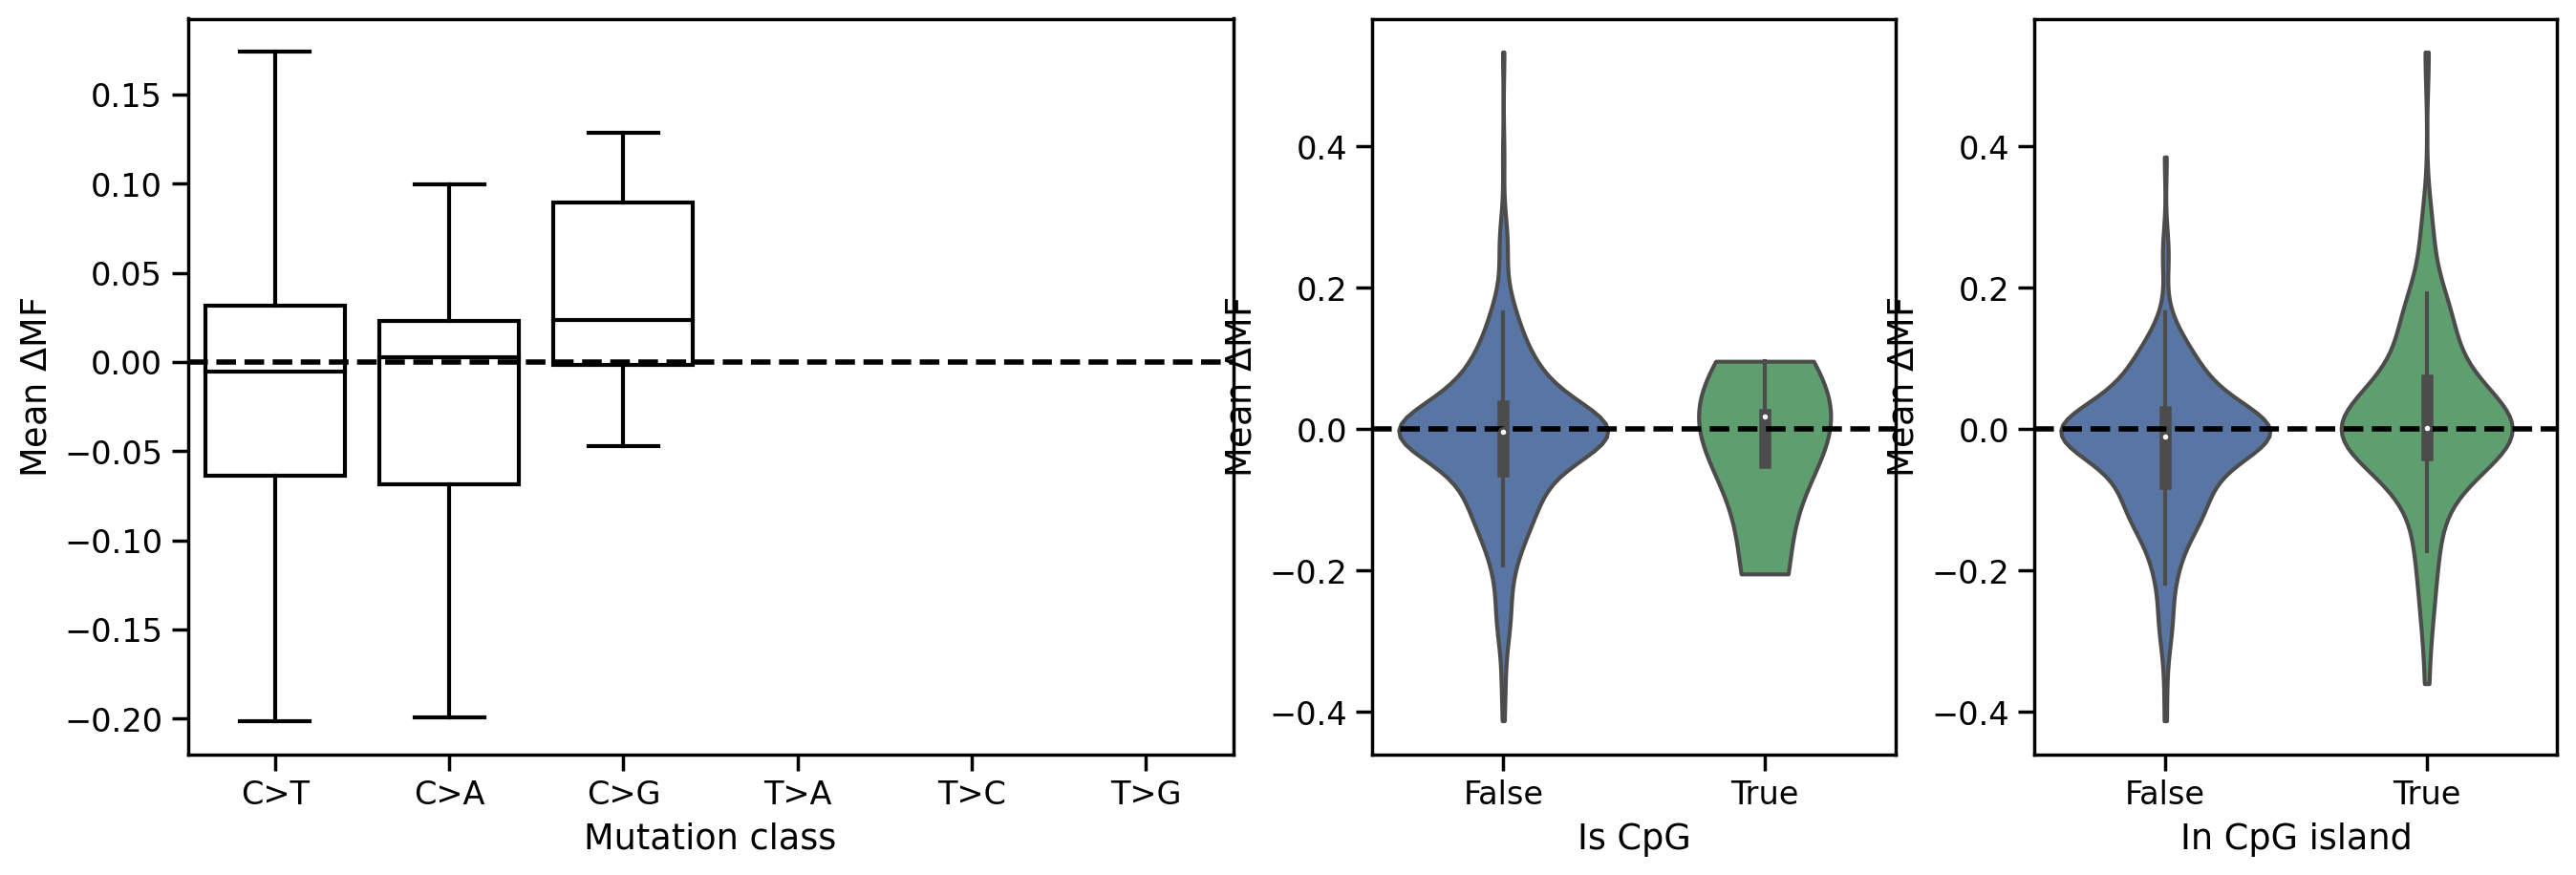

In [58]:
sns.set_context('notebook', font_scale=1.1)
# make two subplots difference sizes
fig, axes = plt.subplots(1,3, figsize = (16, 5), gridspec_kw={'width_ratios': [2, 1, 1]}, sharey=False)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
sns.boxplot(
    data = corr_mean_metrics_w_mut.loc[corr_mean_metrics_w_mut['is_background'] == False],
    x = 'mut_type_combined', y = 'mean_dmf', showfliers = False,
    ax = axes[0], order = ['C>T', 'C>A', 'C>G', 'T>A', 'T>C', 'T>G'],
    **PROPS
)
# plot y= 0
axes[0].axhline(y = 0, color = 'black', linestyle = '--', linewidth = 2)
axes[0].set_ylabel(r'Mean $\Delta$MF')
axes[0].set_xlabel('Mutation class')


sns.violinplot(
    data = corr_mean_metrics_w_mut,
    x = 'becomes_cpg', y = 'mean_dmf', 
    #hue = 'is_background', 
    ax = axes[1],split = True, cut =0
)
# plot y= 0
axes[1].axhline(y = 0, color = 'black', linestyle = '--', linewidth = 2)
axes[1].set_ylabel(r'Mean $\Delta$MF')
axes[1].set_xlabel('Is CpG')

sns.violinplot(
    data = corr_mean_metrics_w_mut,
    x = 'is_cgi', y = 'mean_dmf', 
    #hue = 'is_background',
    ax = axes[2], split = True, cut =0
)
# plot y= 0
axes[2].axhline(y = 0, color = 'black', linestyle = '--', linewidth = 2)
axes[2].set_ylabel(r'Mean $\Delta$MF')
axes[2].set_xlabel('In CpG island')

### Mutation motifs

In [61]:
from Bio import motifs
from Bio.Seq import Seq

In [66]:
handle = open("/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/topEnriched.313.meme")
"""record = motifs.parse(handle, "meme")
handle.close()"""

'record = motifs.parse(handle, "meme")\nhandle.close()'

In [67]:
# porint lines
for line in handle:
    print(line)
    break

MEME version 4.5



# Figure 3

### Correlation 3B

In [134]:
chr1_cpgs = illumina_cpg_locs_df.loc[illumina_cpg_locs_df['chr'] == '1', '#id'].values
chr1_w_methyl_cpgs = set(chr1_cpgs).intersection(set(all_methyl_age_df_t.columns))

In [135]:
chr1_dist_df = utils.get_distances_one_chrom_new('1', illumina_cpg_locs_df)

In [136]:
chr1_corrs = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/dependency_files/all_corrs_chrom1_PANCAN.parquet')

In [352]:
del chr1_corrs, chr1_dist_df

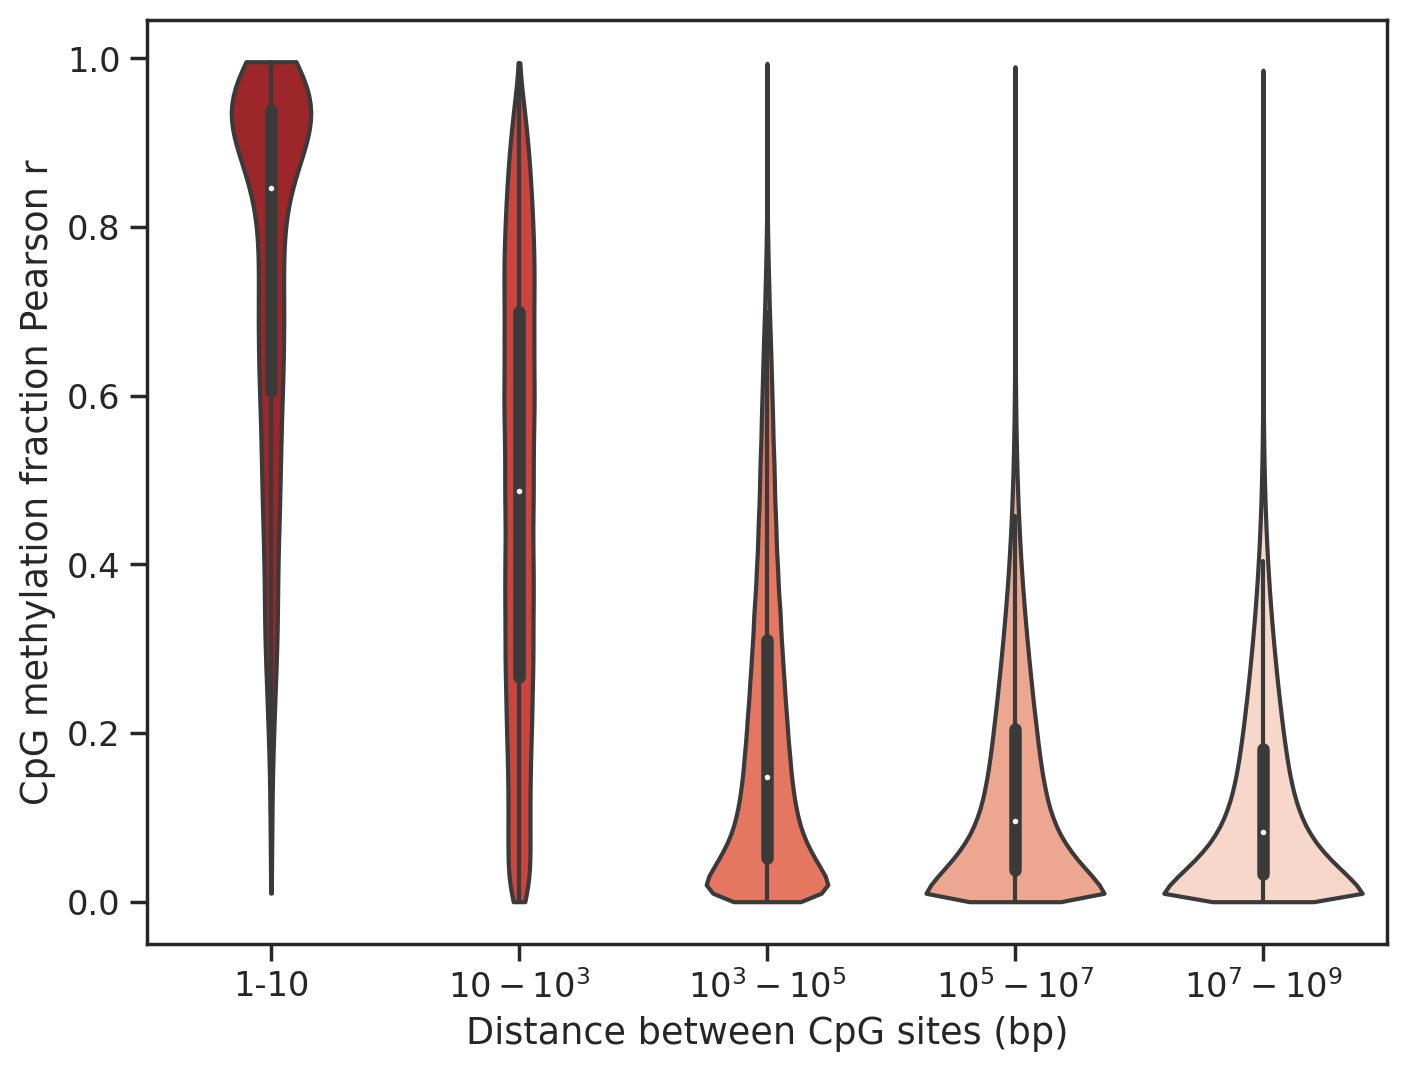

In [350]:
utils.plot_corr_vs_dist(np.abs(chr1_corrs), chr1_dist_df.loc[chr1_corrs.index, chr1_corrs.columns])

In [ ]:
utils.plot_corr_vs_dist(np.abs(chr1_corrs), chr1_dist_df.loc[chr1_corrs.index, chr1_corrs.columns])

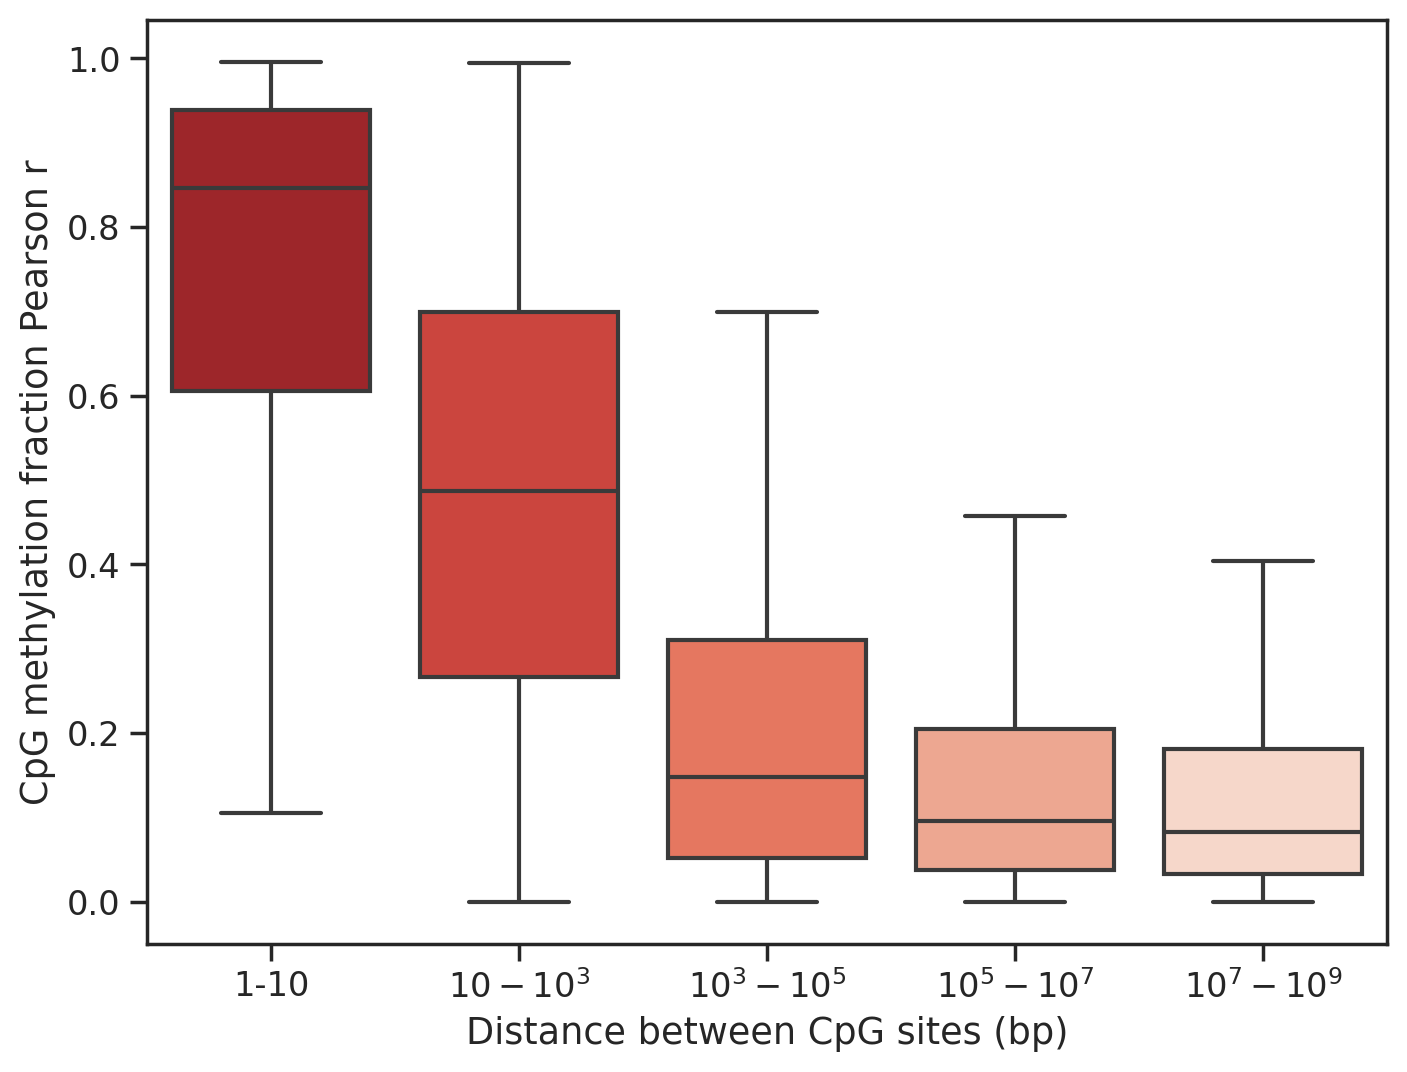

In [351]:
utils.plot_corr_vs_dist(np.abs(chr1_corrs), chr1_dist_df.loc[chr1_corrs.index, chr1_corrs.columns])